In [1]:
import matplotlib.pyplot as plt
import math

import pandas as pd
from utils import DEGREES_PER_PIXEL, TIMESTAMP_IDENT, X_PIXELS, Y_PIXELS
from velocityThreshold import detect_fix_ivt


def plot_fixations_on_screenshot(gaze_data, screenshot_path, title, saccadic_threshold):
    fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))
    # set ax limits
    ax.set_xlim(0, X_PIXELS)
    ax.set_ylim(Y_PIXELS, 0)
    img = plt.imread(screenshot_path)
    # normalize timestamps
    timestamps = []
    x = []
    y = []

    # for each packet, plot the gaze point
    for packet in gaze_data["data"]:
        # there are certain points off the screen. ignore these.
        if packet["right_gaze_point_validity"] == 0:
            continue
        elif packet["right_gaze_point_on_display_area"][0] > 1 or packet["right_gaze_point_on_display_area"][1] > 1:
            continue

        x.append(packet["right_gaze_point_on_display_area"][0] * X_PIXELS)
        y.append(packet["right_gaze_point_on_display_area"][1] * Y_PIXELS)
        timestamps.append(packet[TIMESTAMP_IDENT]/1_000_000)

    df = pd.DataFrame({"x": x, "y": y, "ts": timestamps})
    df = df.sort_values(by="ts")
    df = df.reset_index(drop=True)

    df["x"] = df["x"] * DEGREES_PER_PIXEL
    df["y"] = df["y"] * DEGREES_PER_PIXEL

    # plot fixations
    fixations, v, labels = detect_fix_ivt(df, sacvel=saccadic_threshold)

    fixations["x"] = fixations["x"] / DEGREES_PER_PIXEL
    fixations["y"] = fixations["y"] / DEGREES_PER_PIXEL

    # saccades = find_sacc_from_fix(fixations)

    # for index in saccades.index:
    #     saccade = saccades.loc[index]
    #     print(fixations)
    #     print('---')
    #     print(saccade)

    #     point_a = (fixations["x"][saccade['i']], fixations["x"][saccade['i'] + saccade['n']])
    #     point_b = (fixations["y"][saccade['i']], fixations["y"][saccade['i'] + saccade['n']])
    #     # draw an arrow between the two points
    #     ax.arrow(
    #         point_a[0],
    #         point_a[1],
    #         point_b[0] - point_a[0],
    #         point_b[1] - point_a[1],
    #         color="red",
    #         linewidth=1,
    #         linestyle="-",
    #         head_width=10,
    #         head_length=10,
    #     )

    #     # ax.plot(
    #     #     [point_a[0], point_b[0]],
    #     #     [point_a[1], point_b[1]],
    #     #     color="red",
    #     #     linewidth=1,
    #     #     linestyle="-",
    #     # )

    p = ax.scatter(fixations["x"], fixations["y"], c=fixations["ts"], s=40, cmap="plasma")

    # take successive fixations and draw an arrow between them.
    for a, b in zip(fixations.index[:-1], fixations.index[1:]):
        point_a = (fixations["x"][a], fixations["y"][a])
        point_b = (fixations["x"][b], fixations["y"][b])
        # draw an arrow between the two points

        color = "black"

        opp = point_b[1] - point_a[1]
        adj = point_b[0] - point_a[0]
        angle = math.degrees(math.atan2(opp, adj))
        # make the angles between 0 and 360
        if angle < 0:
            angle = 360 + angle

        if 0 < angle < 20 or 340 < angle < 360:
            color = "green" # saccade
        elif 45 < angle < 181:
            color = "blue" # return sweep
        elif 181 < angle < 220:
            color = "red" # regression
        else:
            color = "purple"

        ax.arrow(
            point_a[0],
            point_a[1],
            point_b[0] - point_a[0],
            point_b[1] - point_a[1],
            color=color,
            alpha=0.5,
            width=0.1,
            head_width=10,
            length_includes_head=True,
        )

    # show color bar for timestamps
    fig.colorbar(p, ax=ax)
    ax.imshow(img, extent=[0, X_PIXELS, Y_PIXELS, 0])
    ax.set_title(title)


/Users/shady/Git/school/flow/apps/backend/velocityThreshold.py:62: RuntimeWarning: invalid value encountered in scalar divide
  rho = cov[0,1] / (sx*sy)
/Users/shady/Git/school/flow/apps/backend/utils.py:171: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(X_PIXELS / 100, Y_PIXELS / 100))


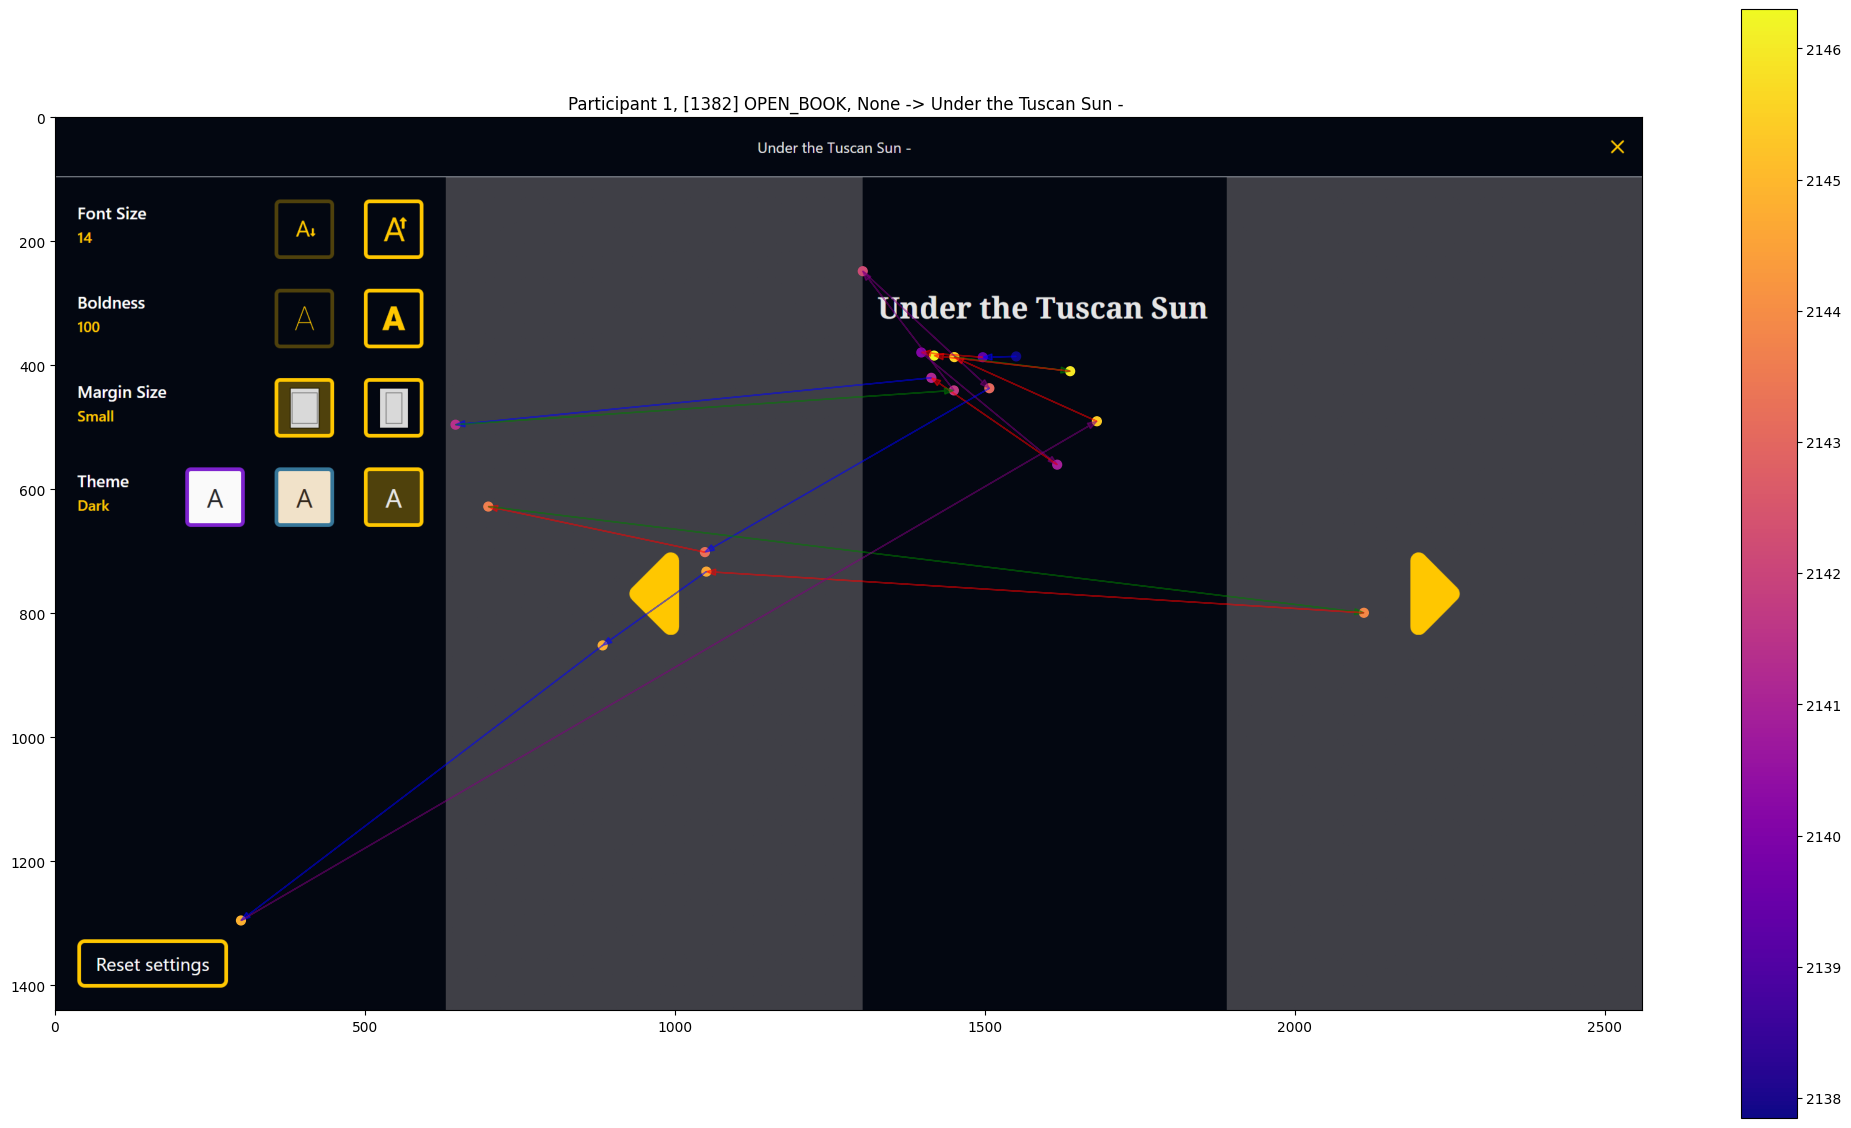

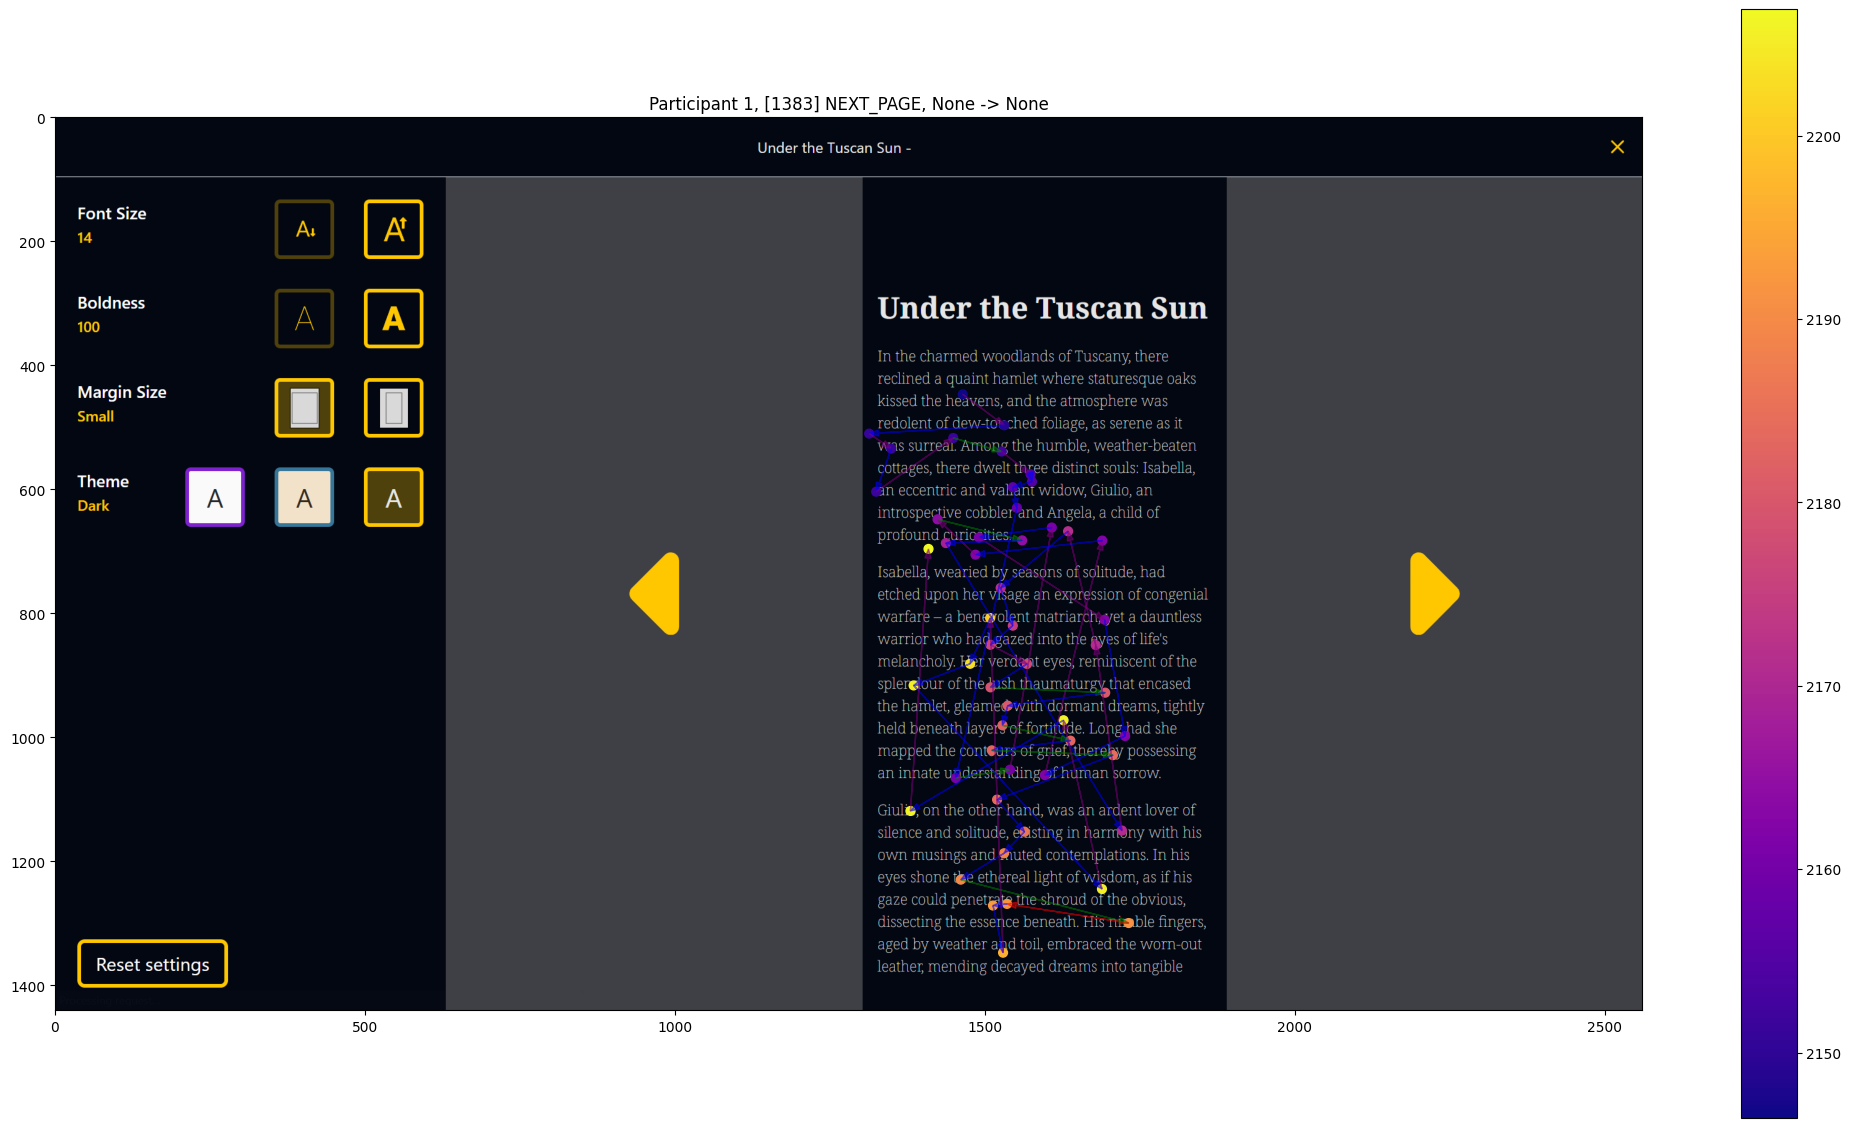

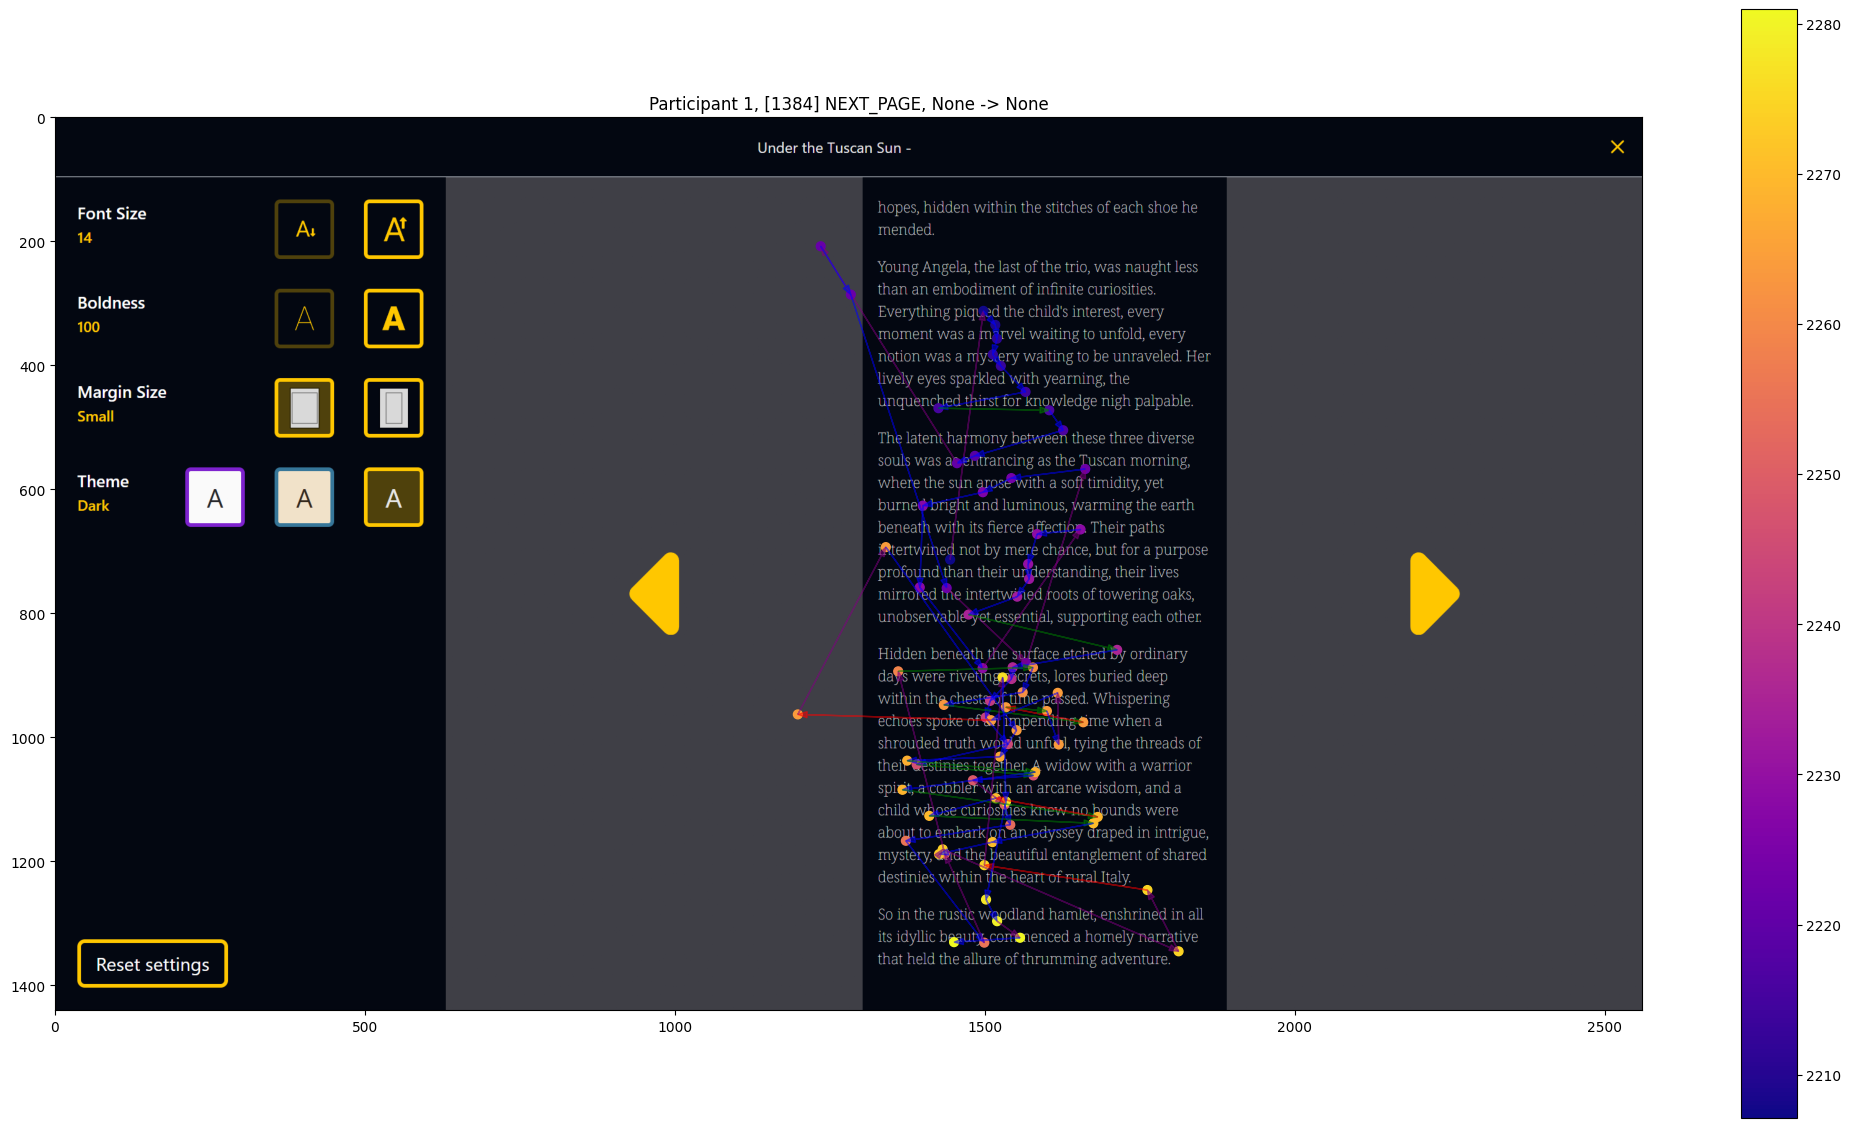

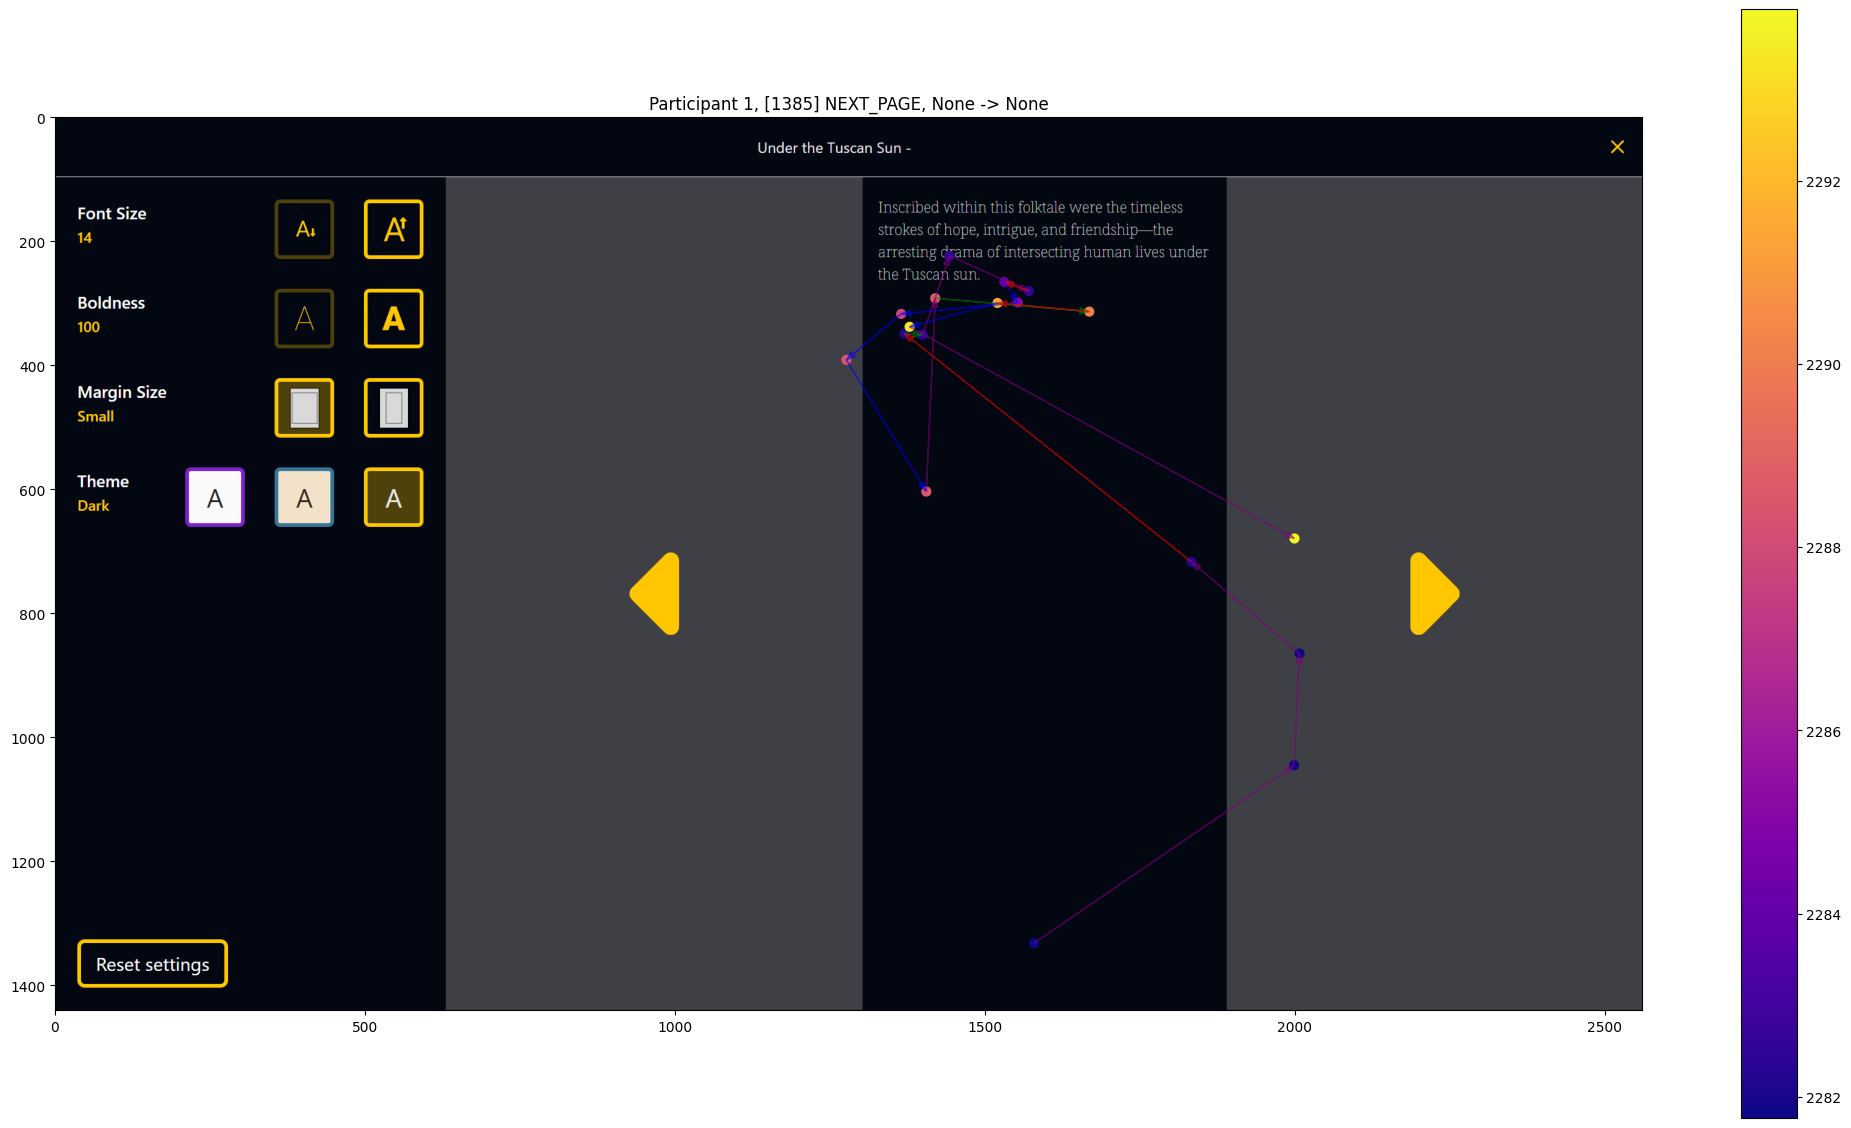

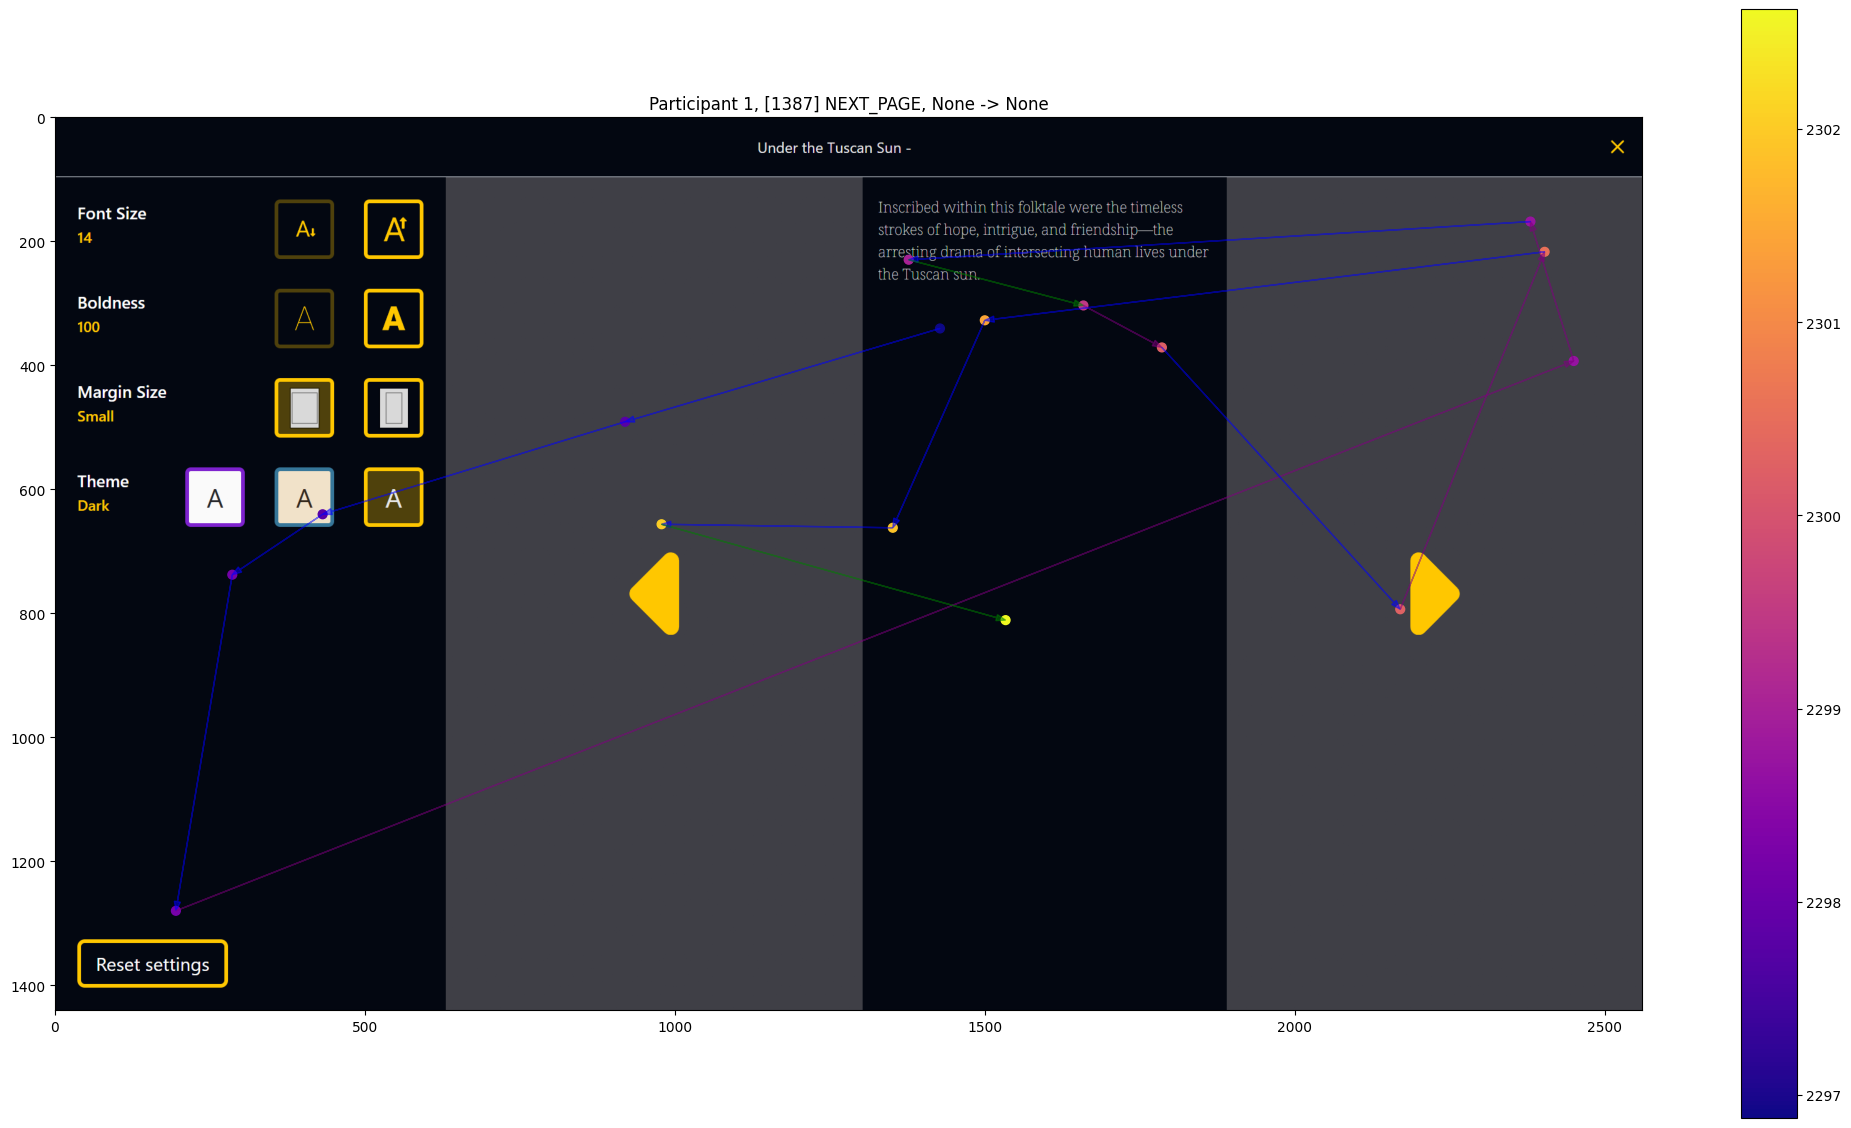

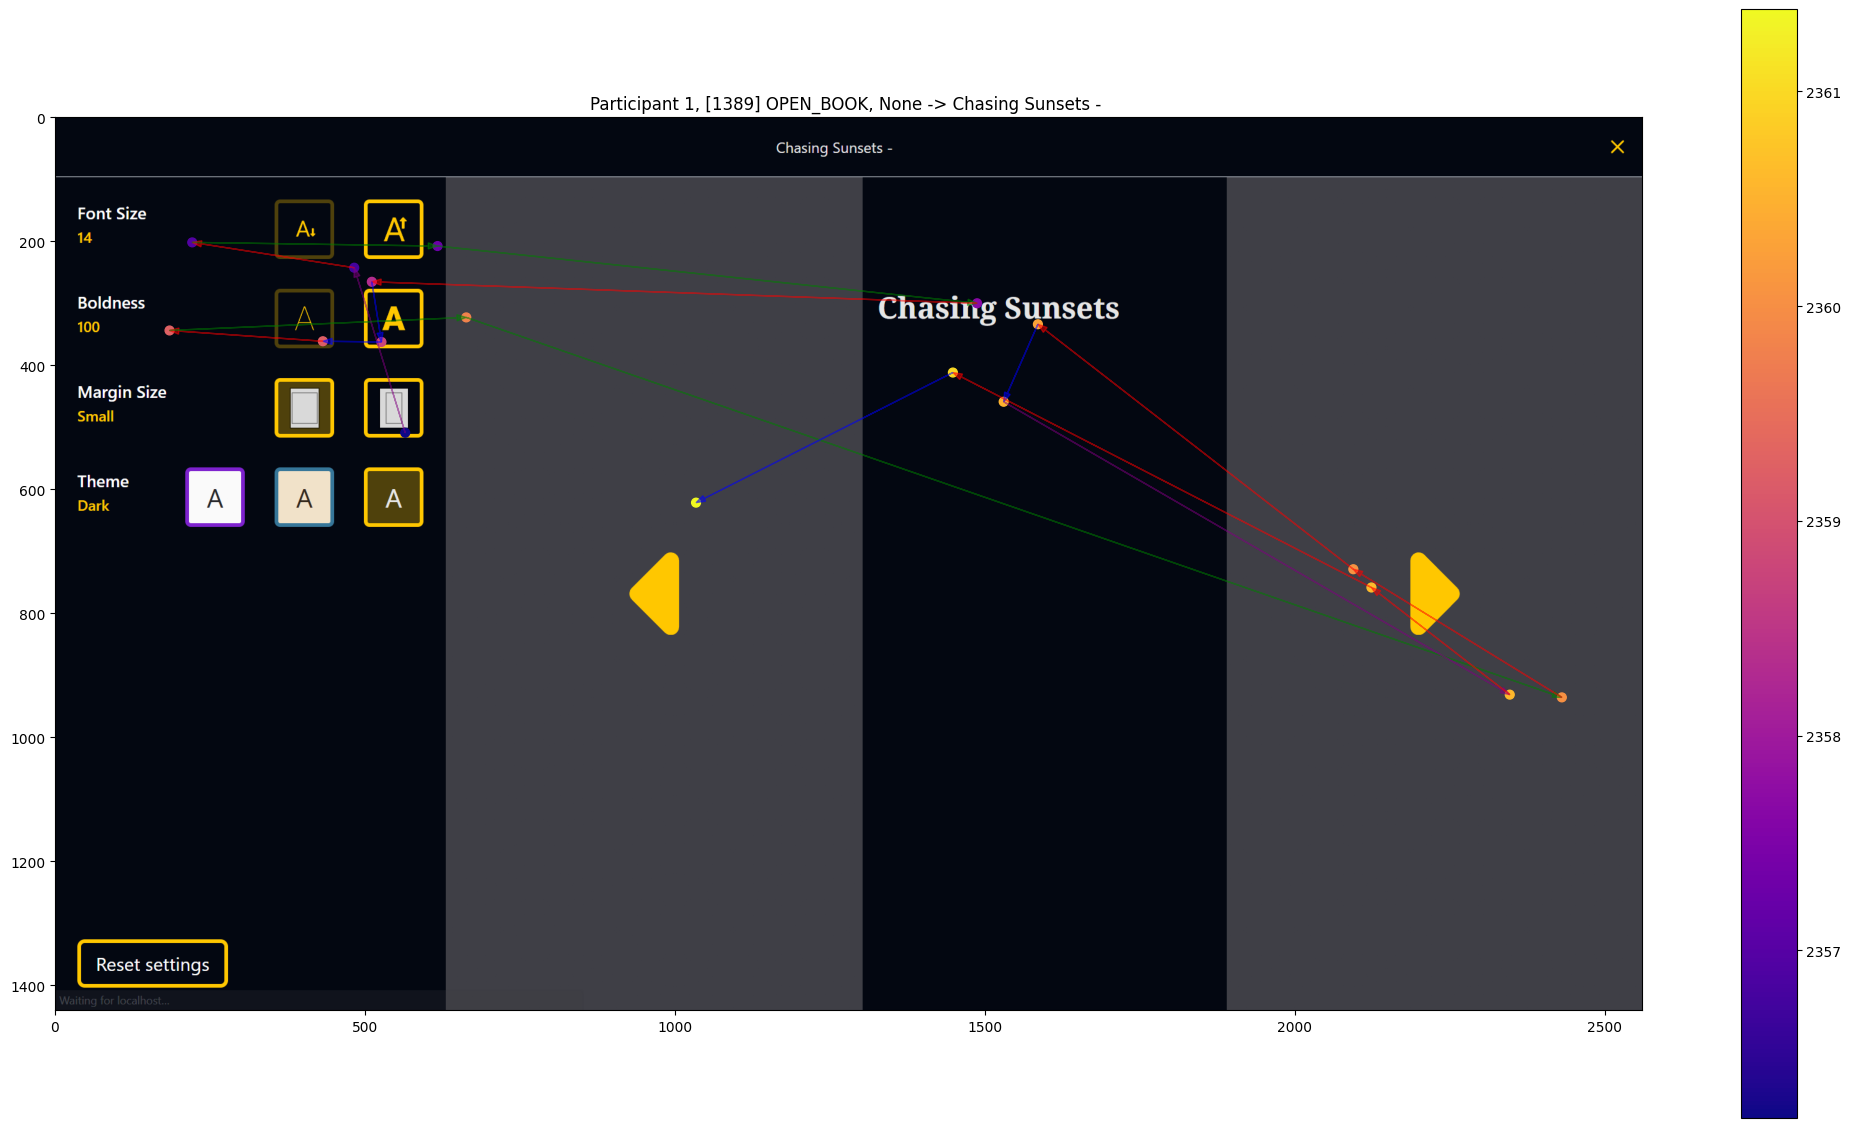

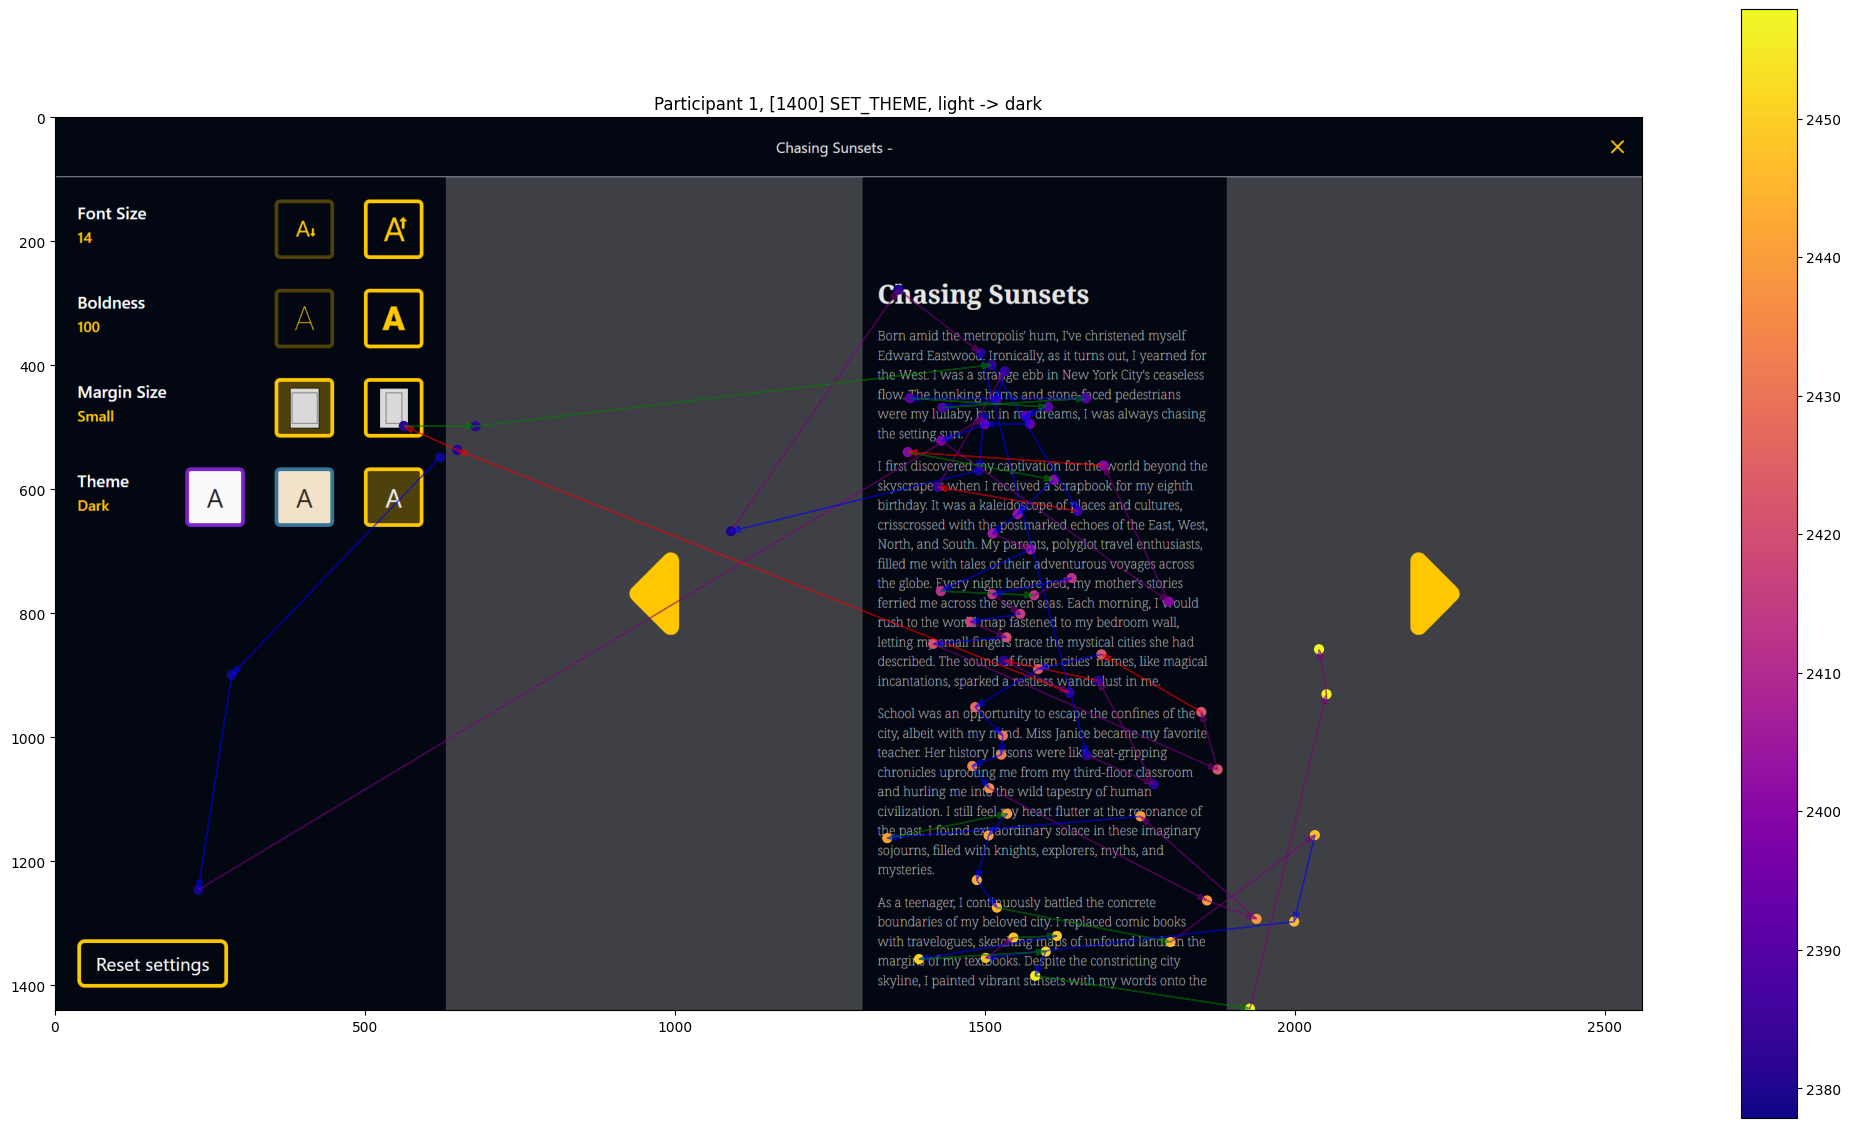

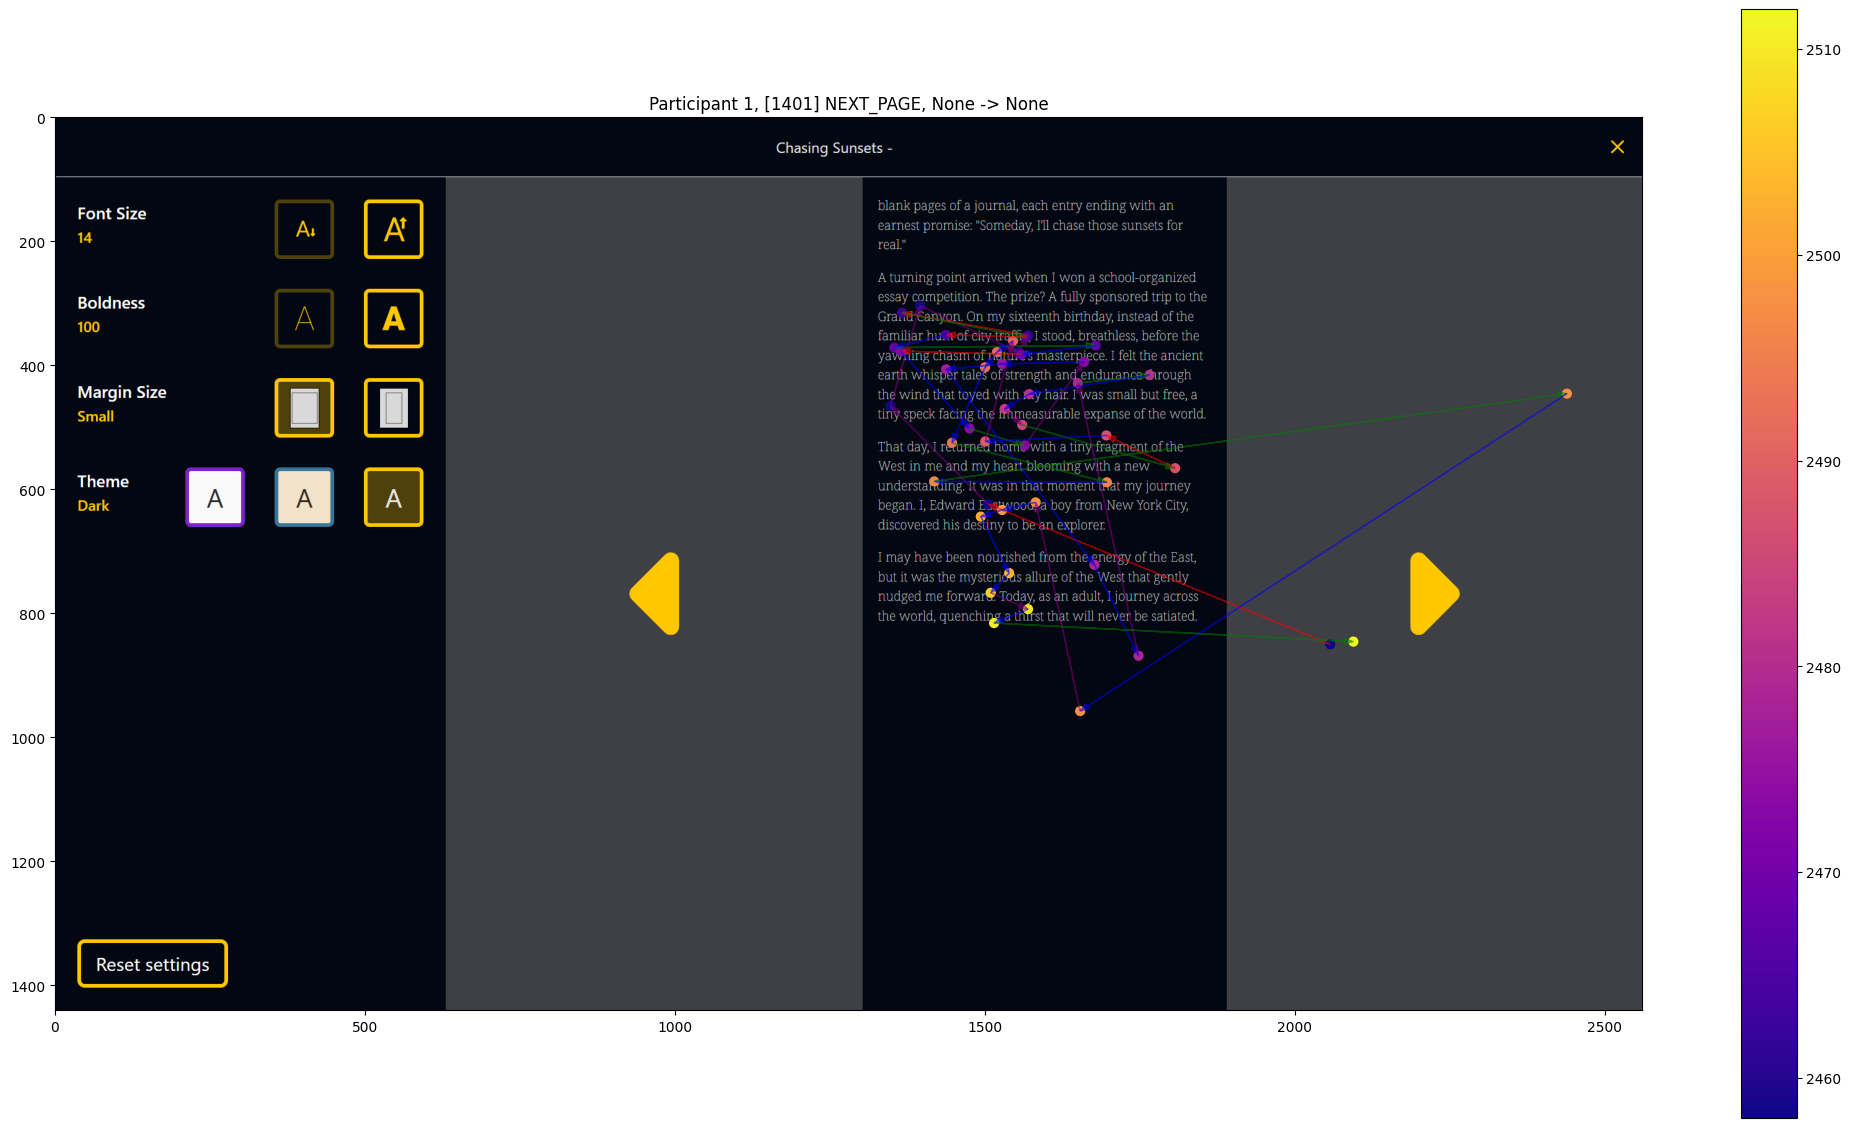

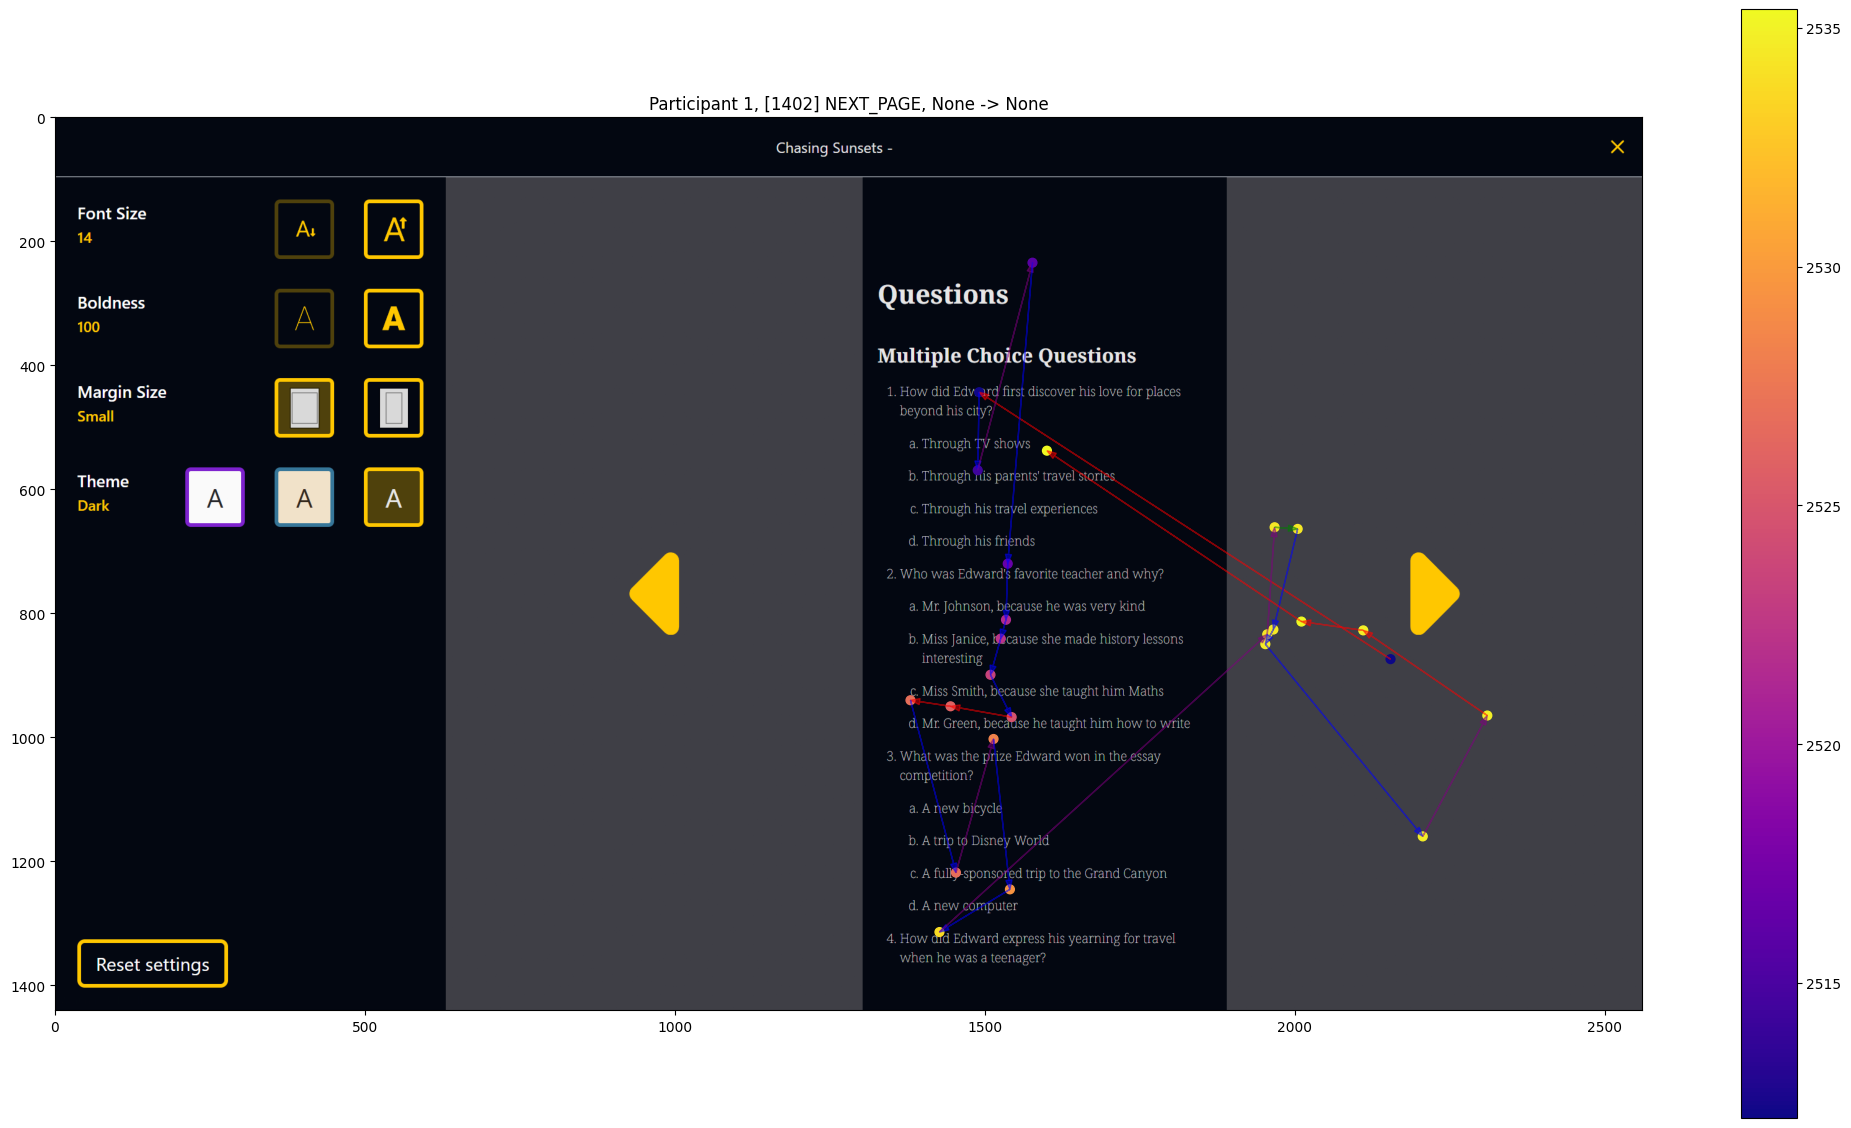

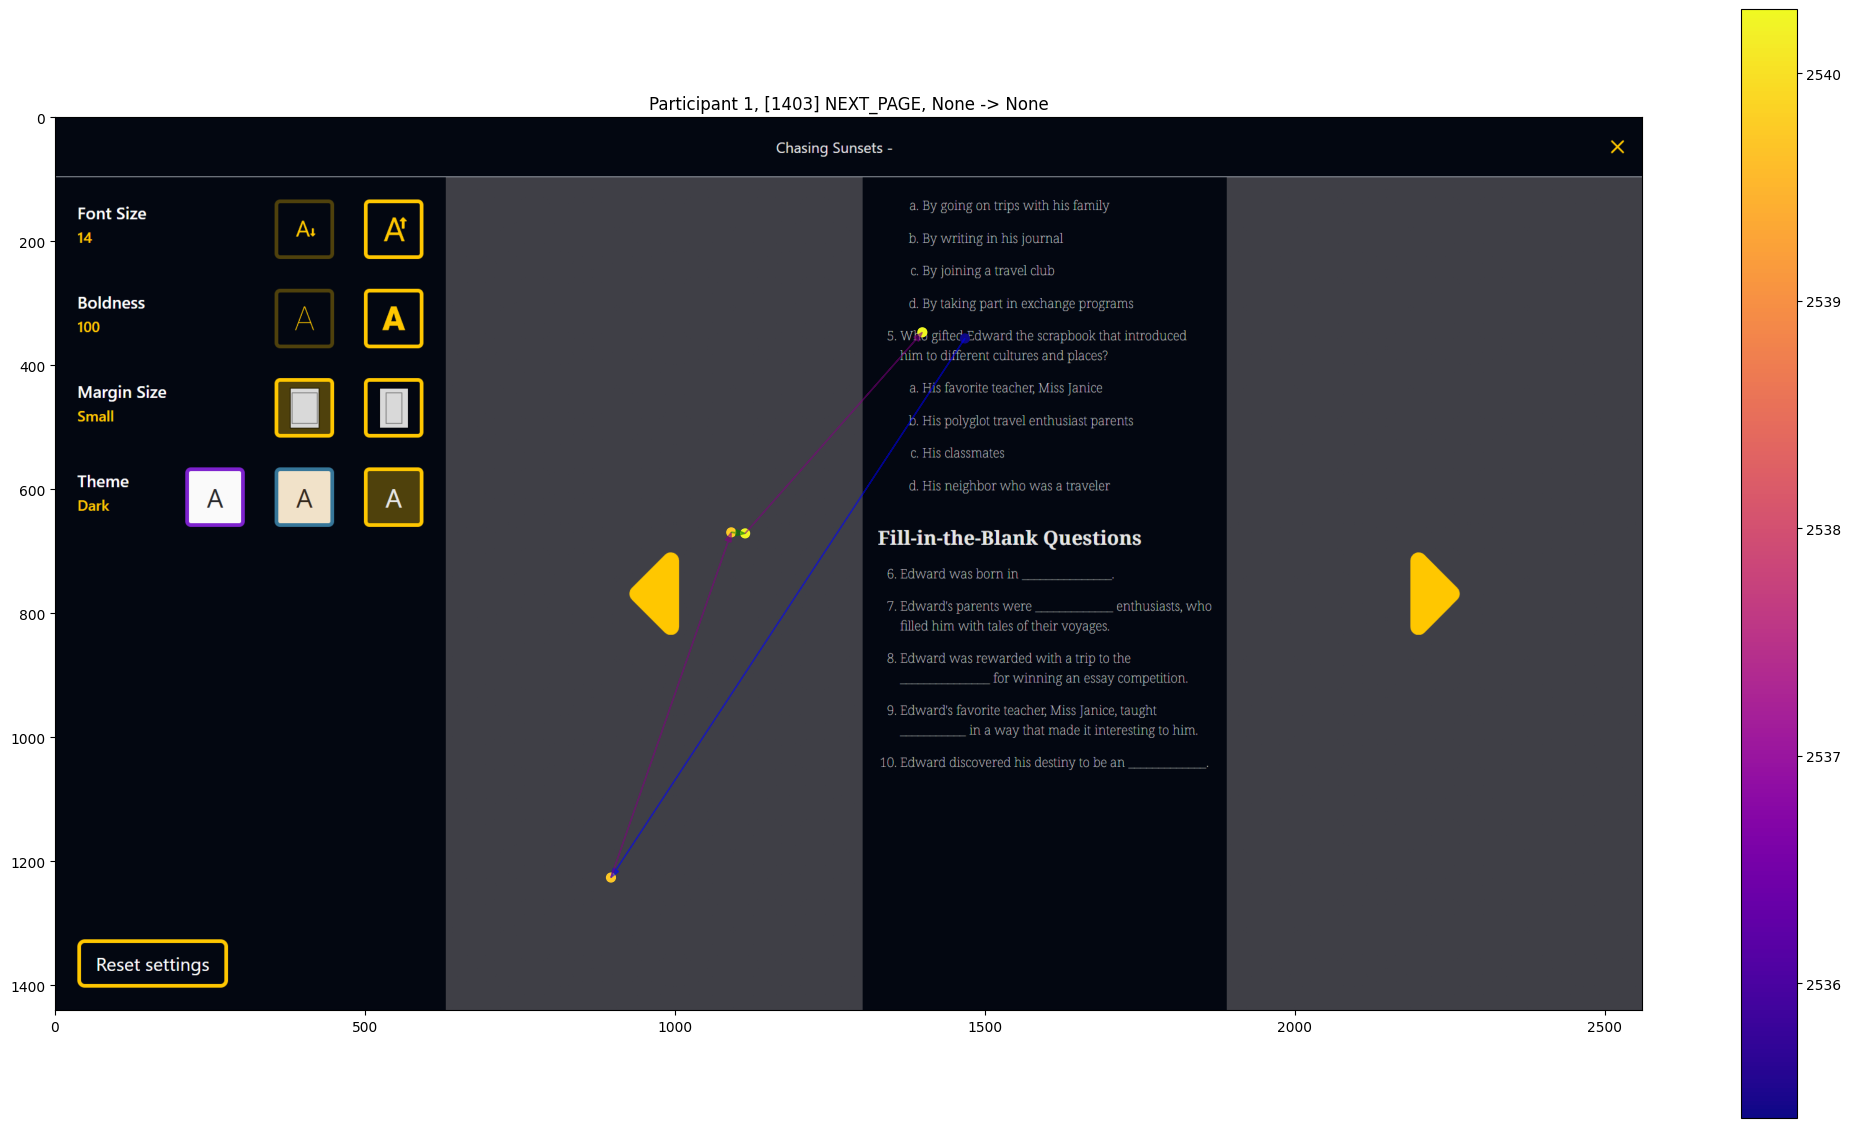

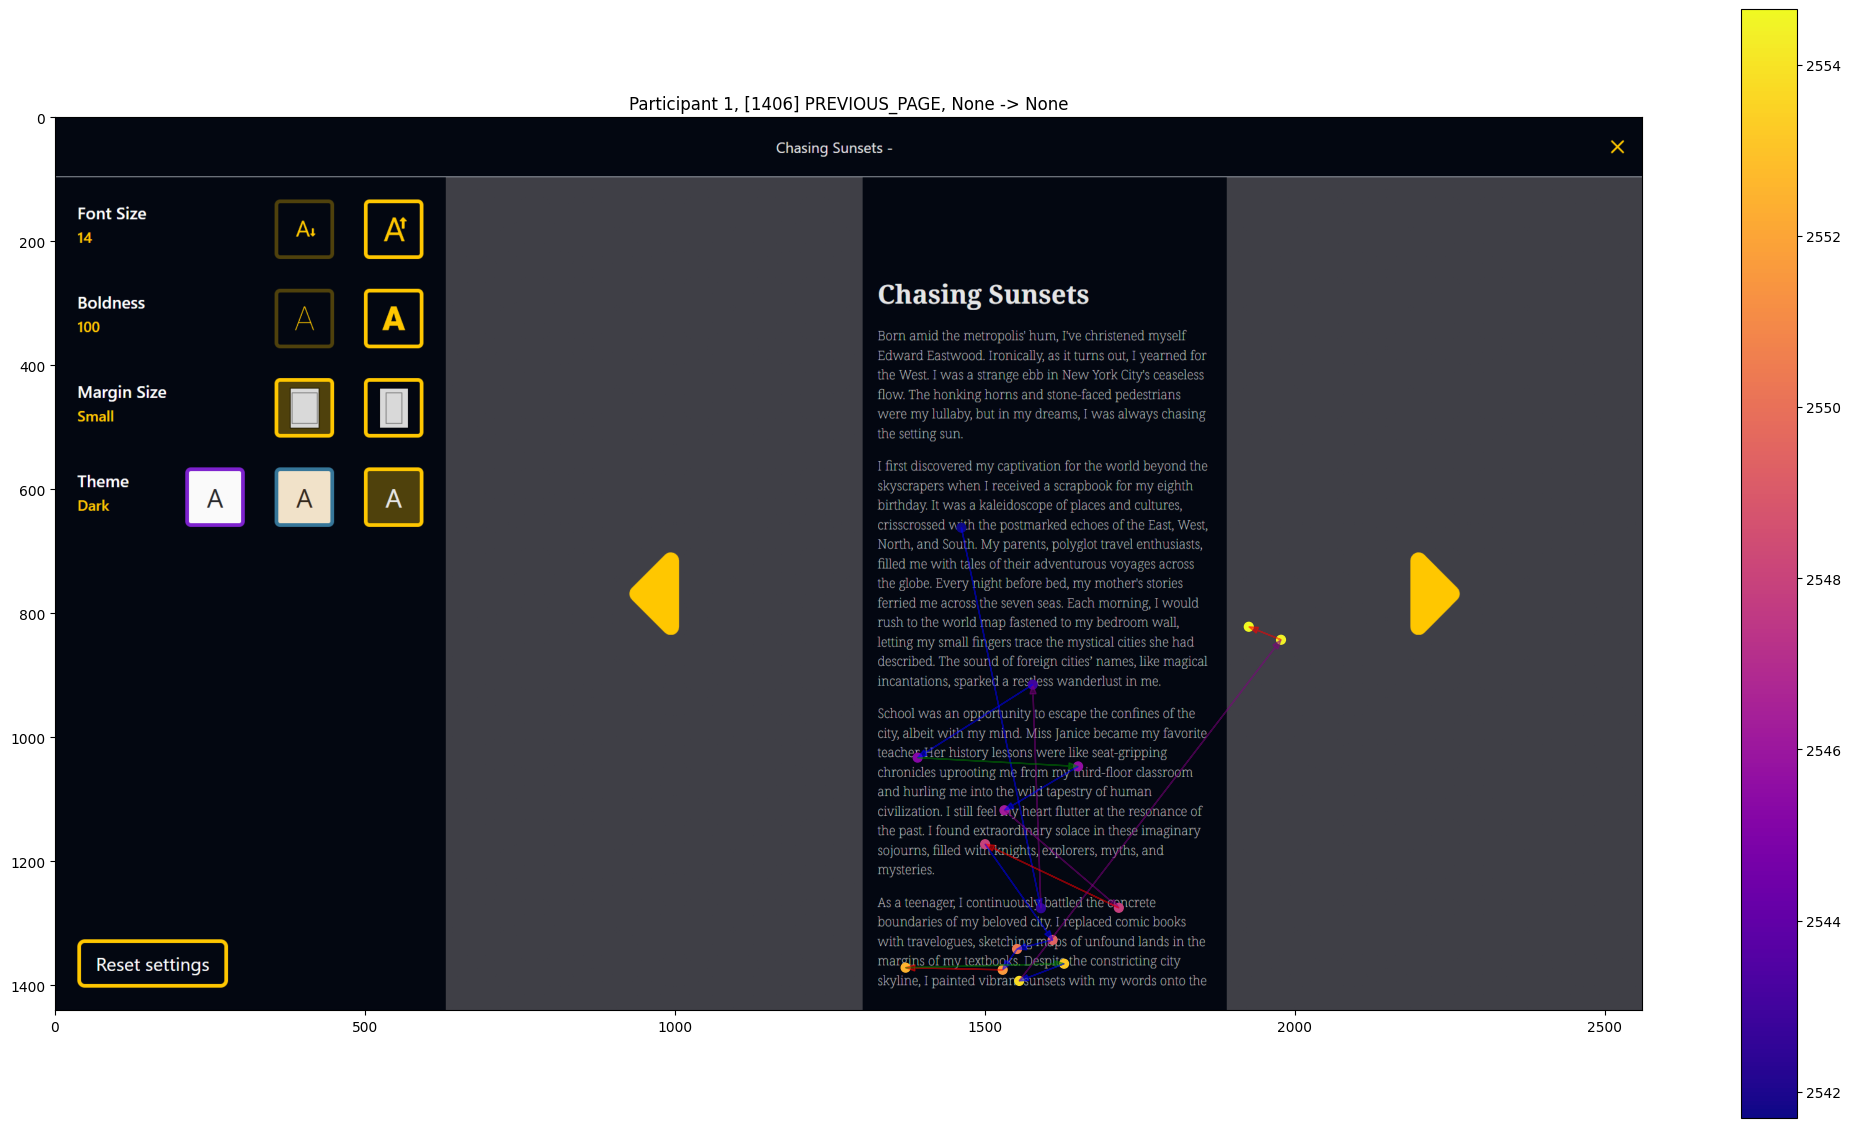

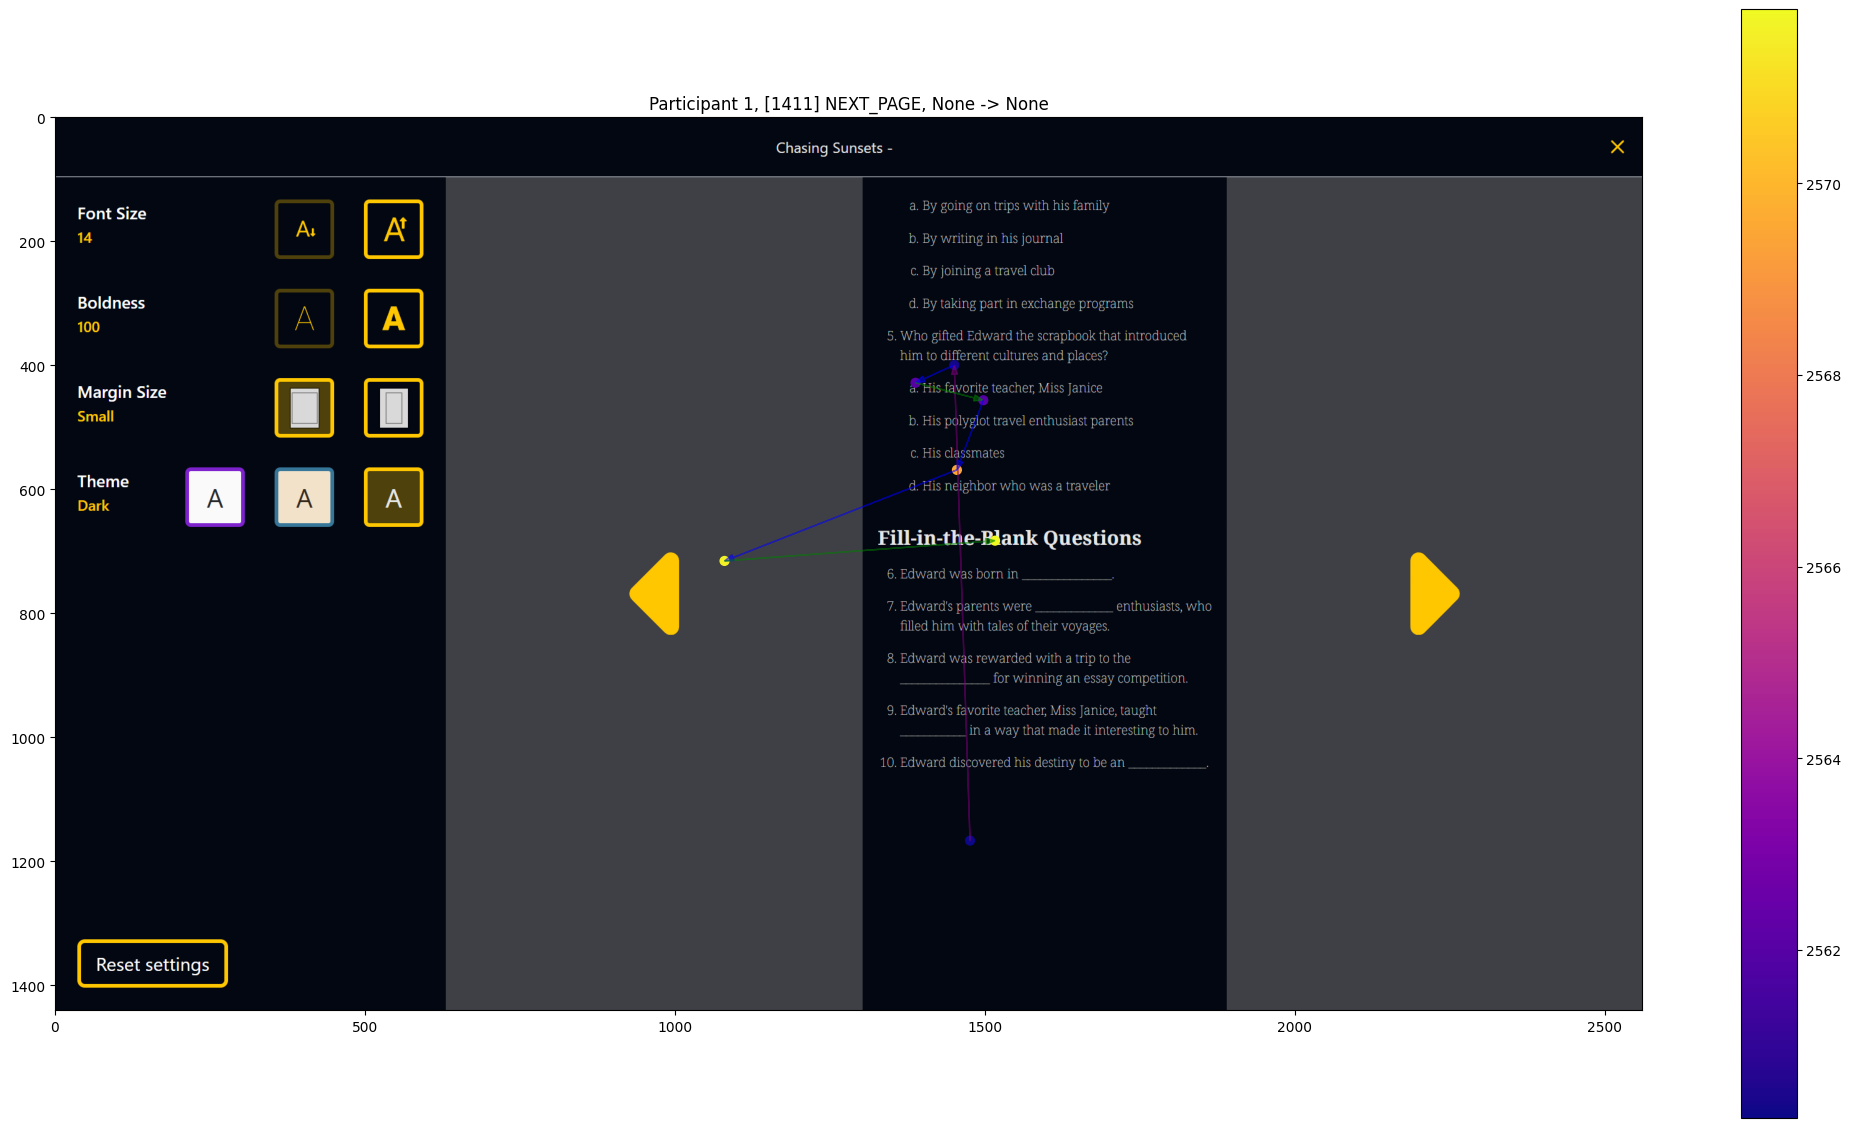

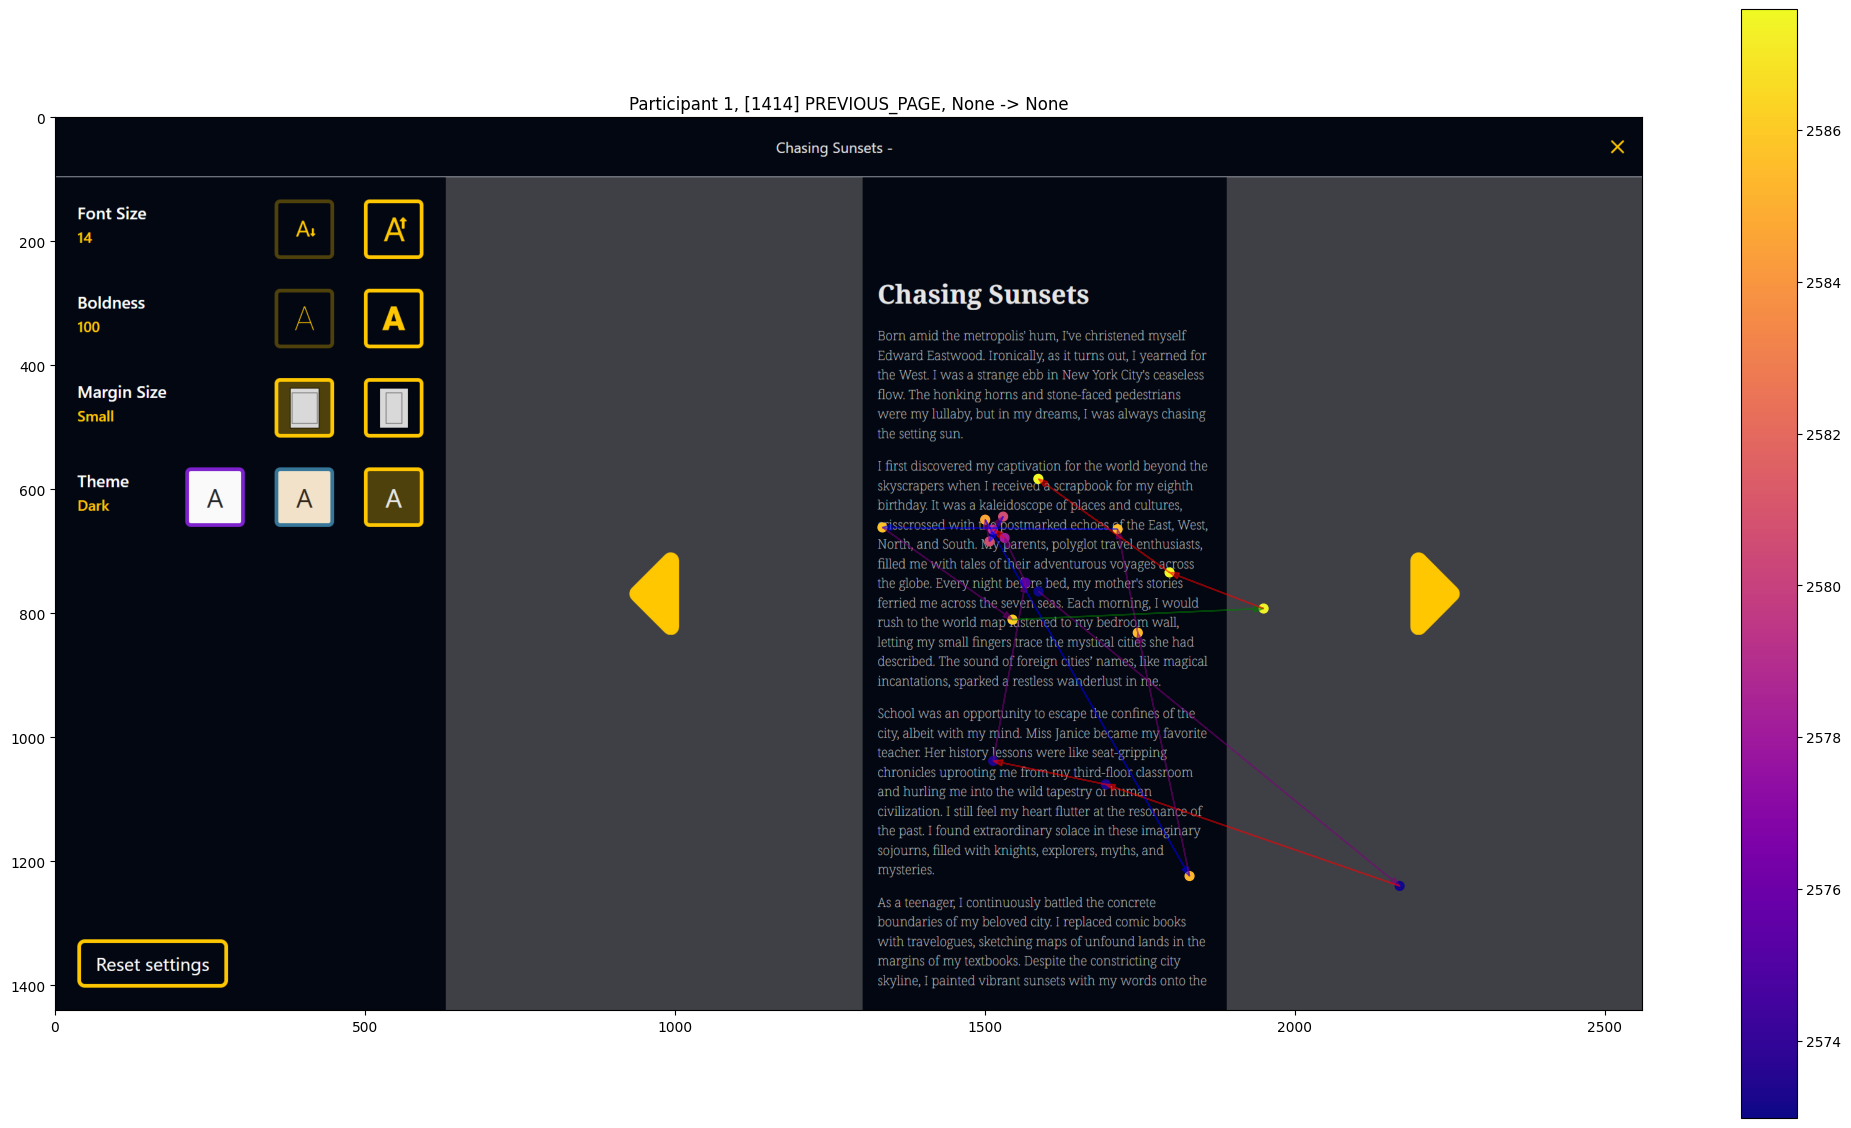

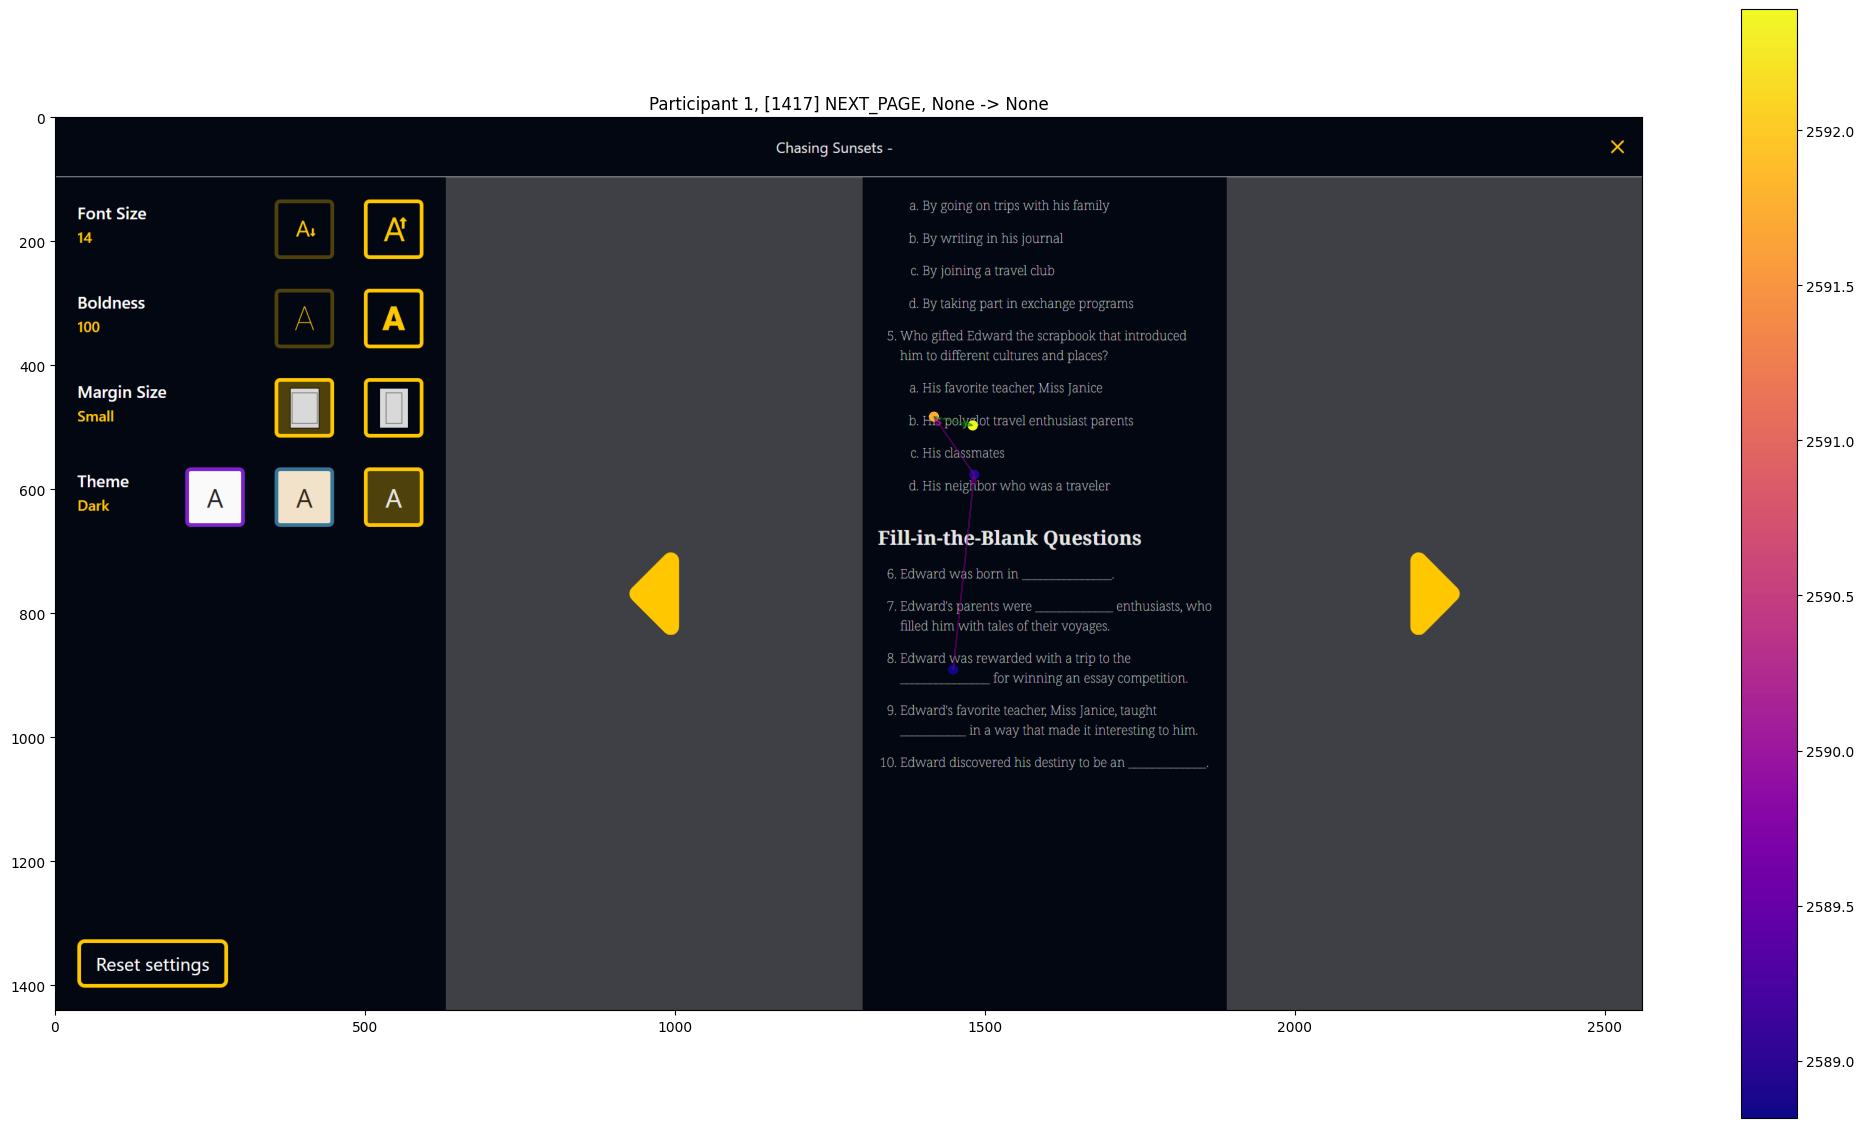

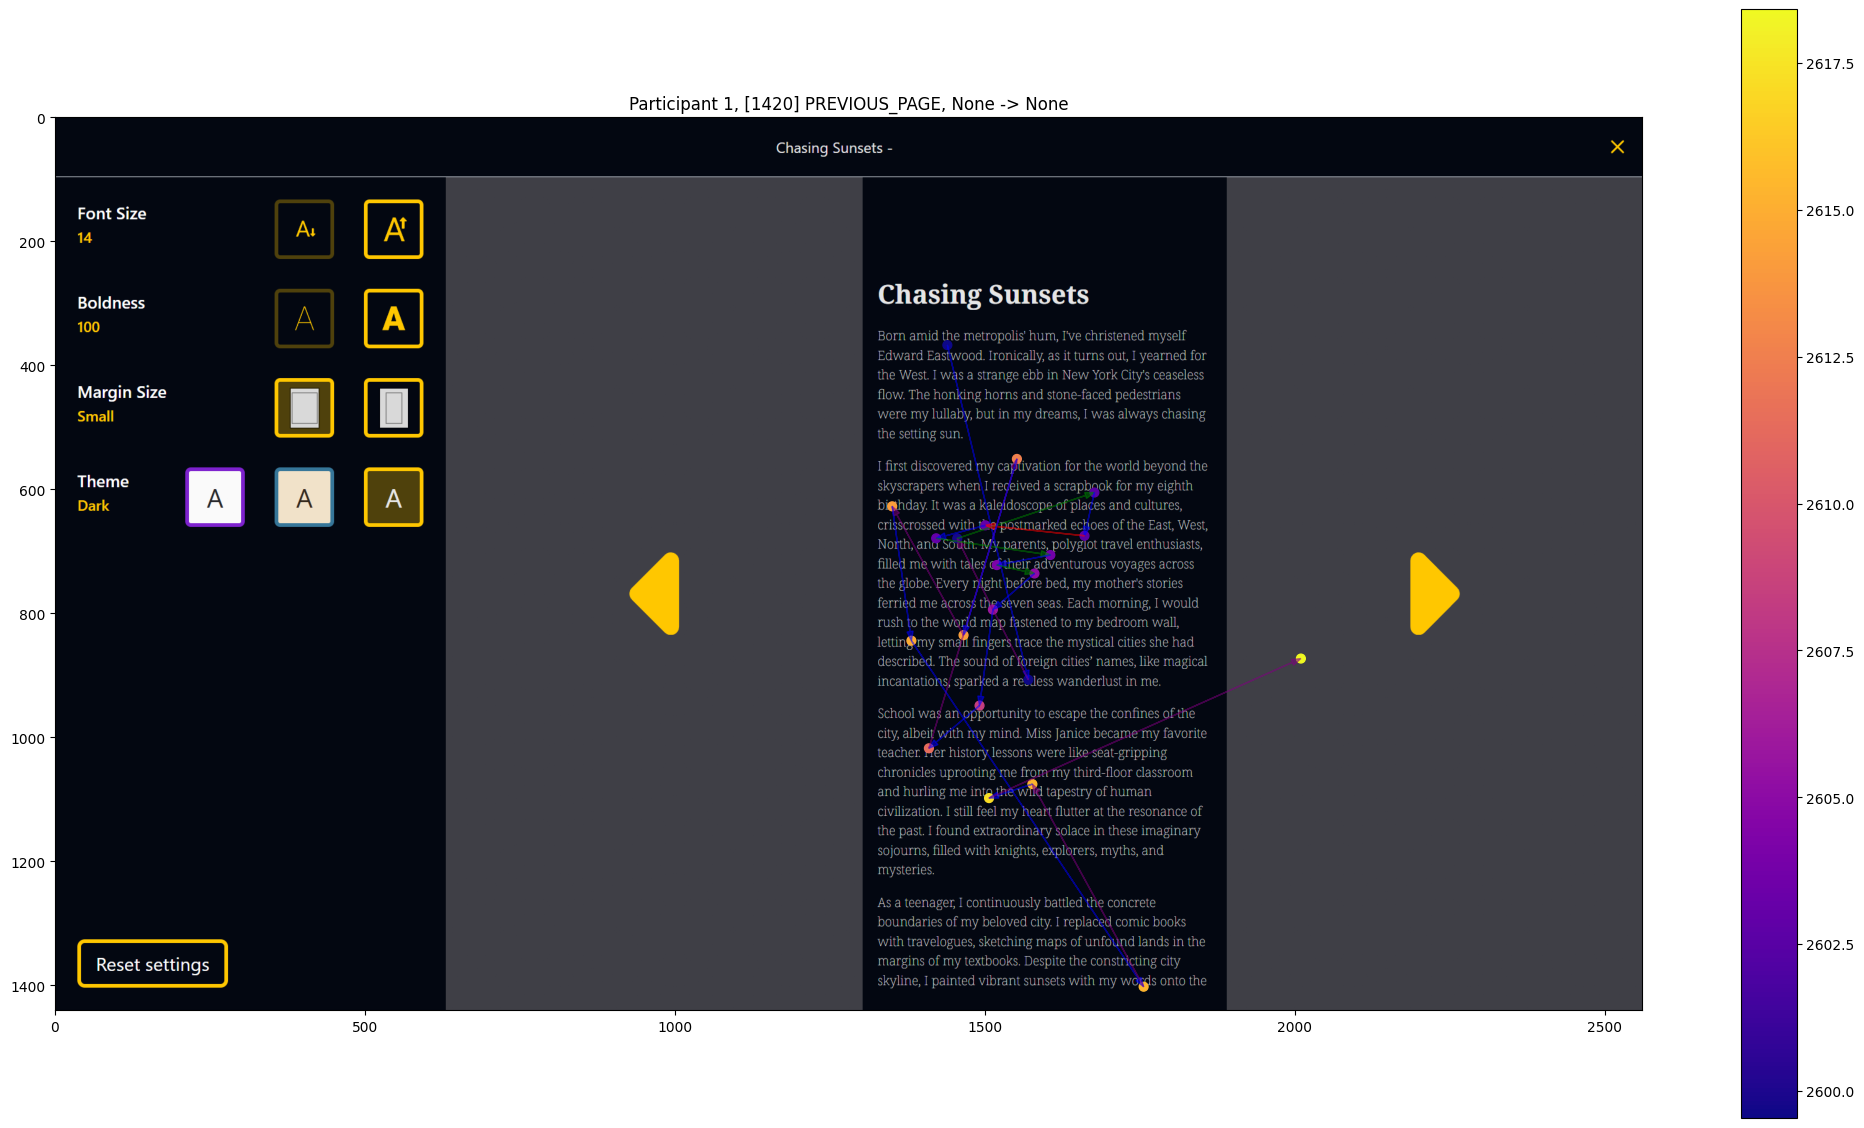

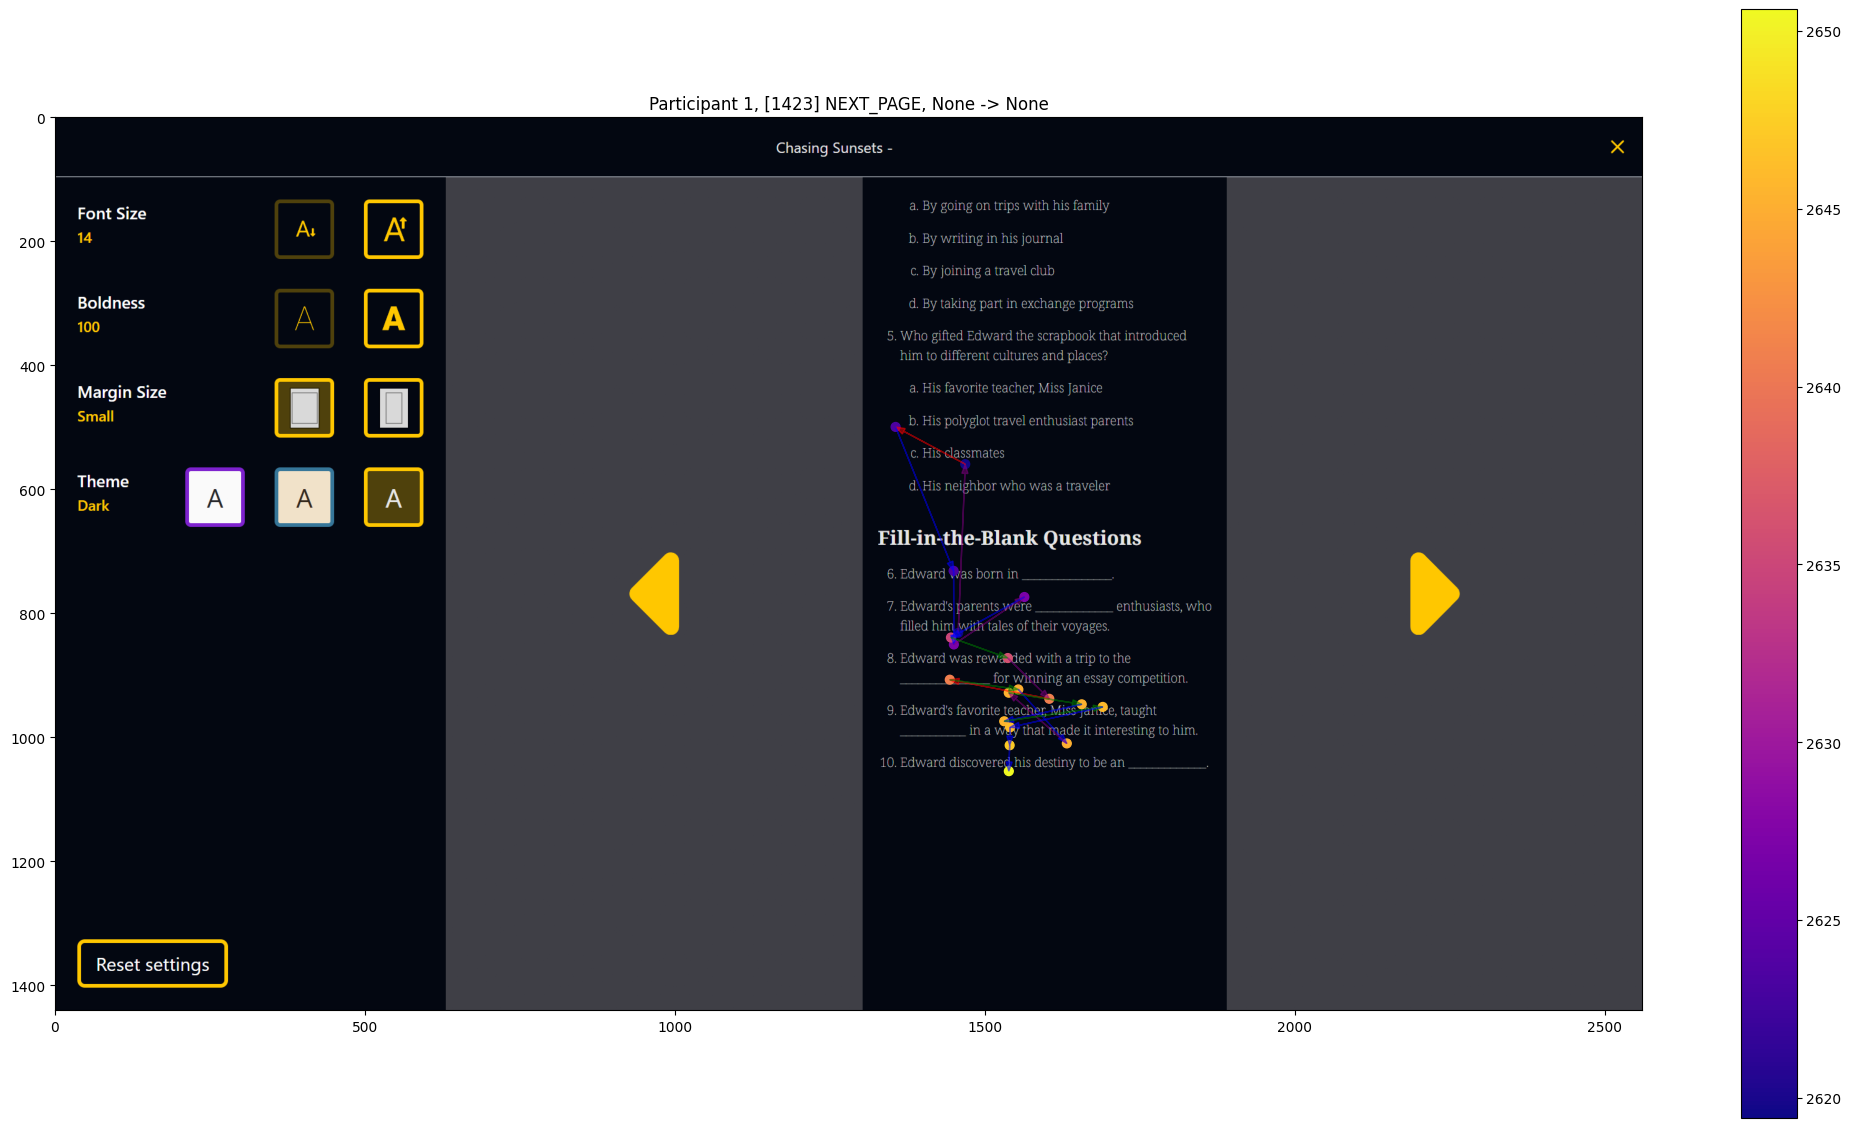

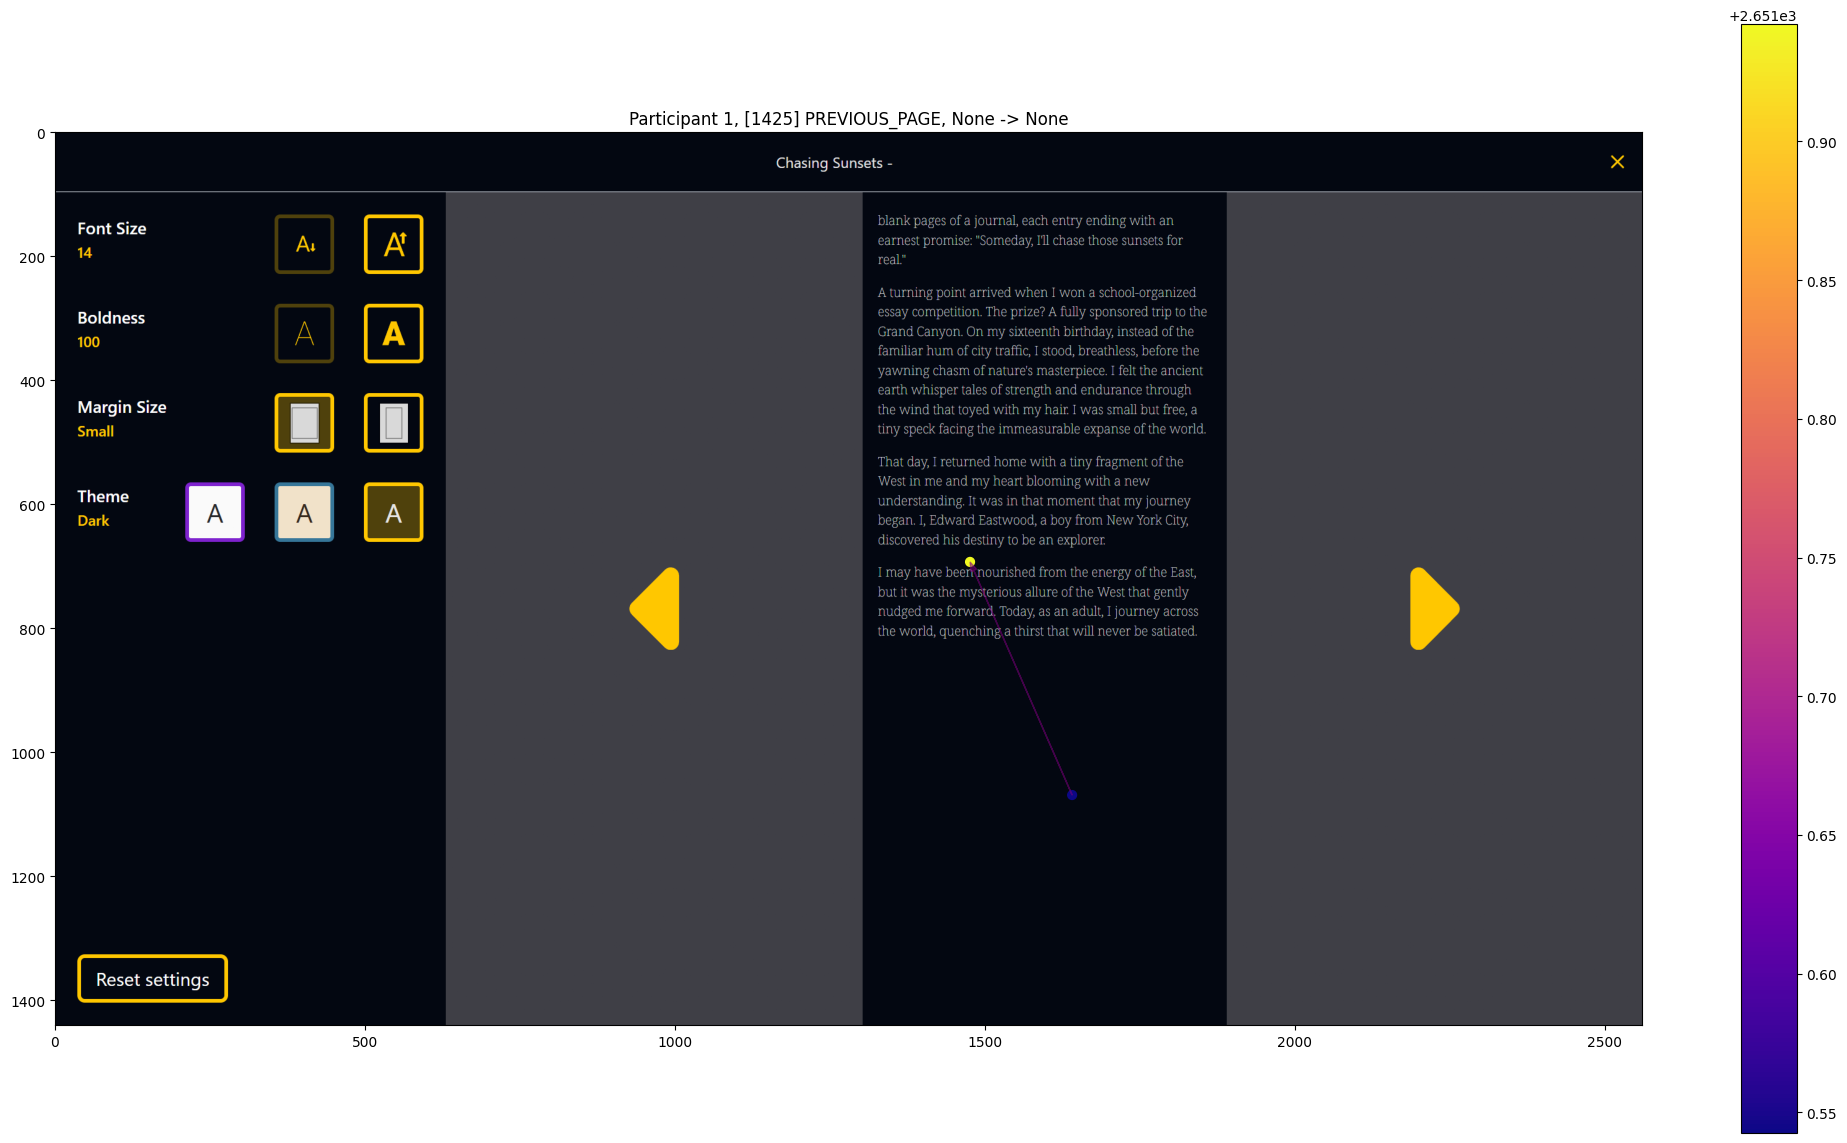

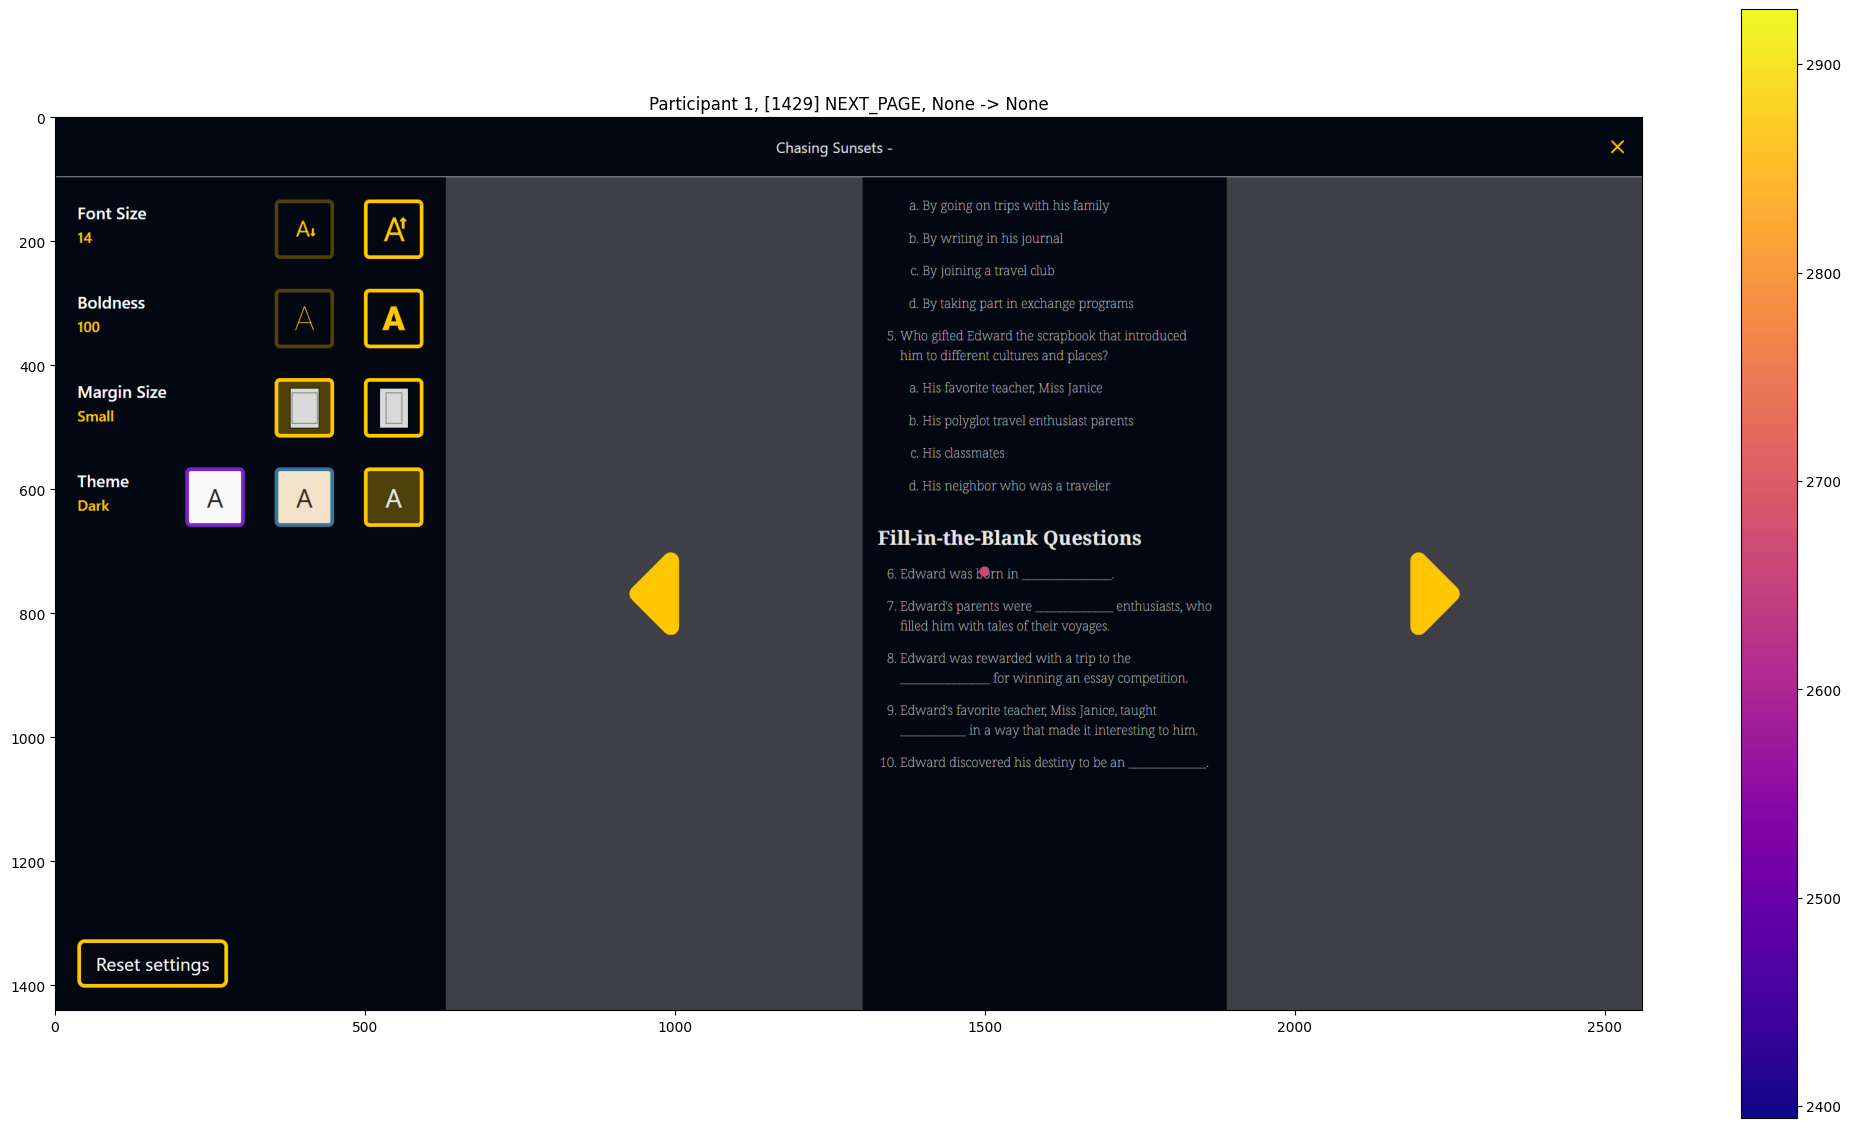

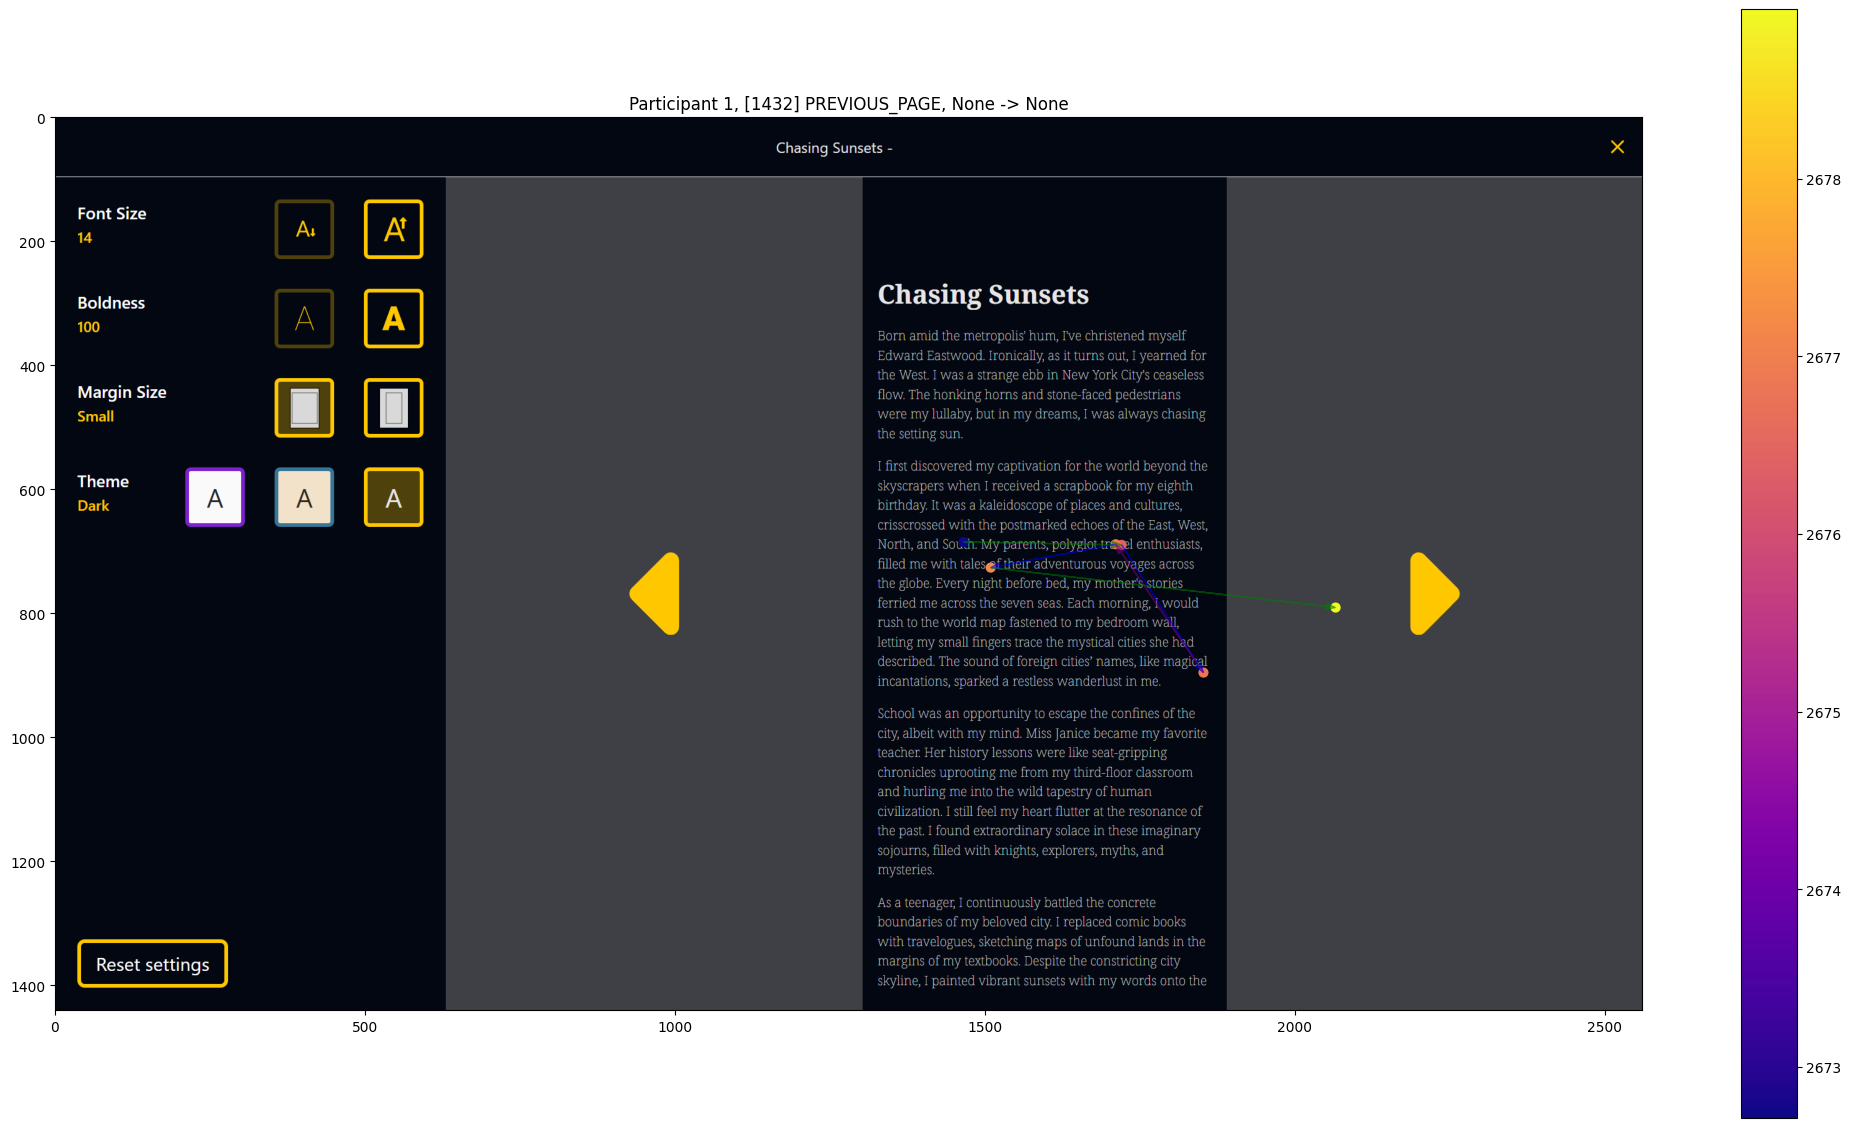

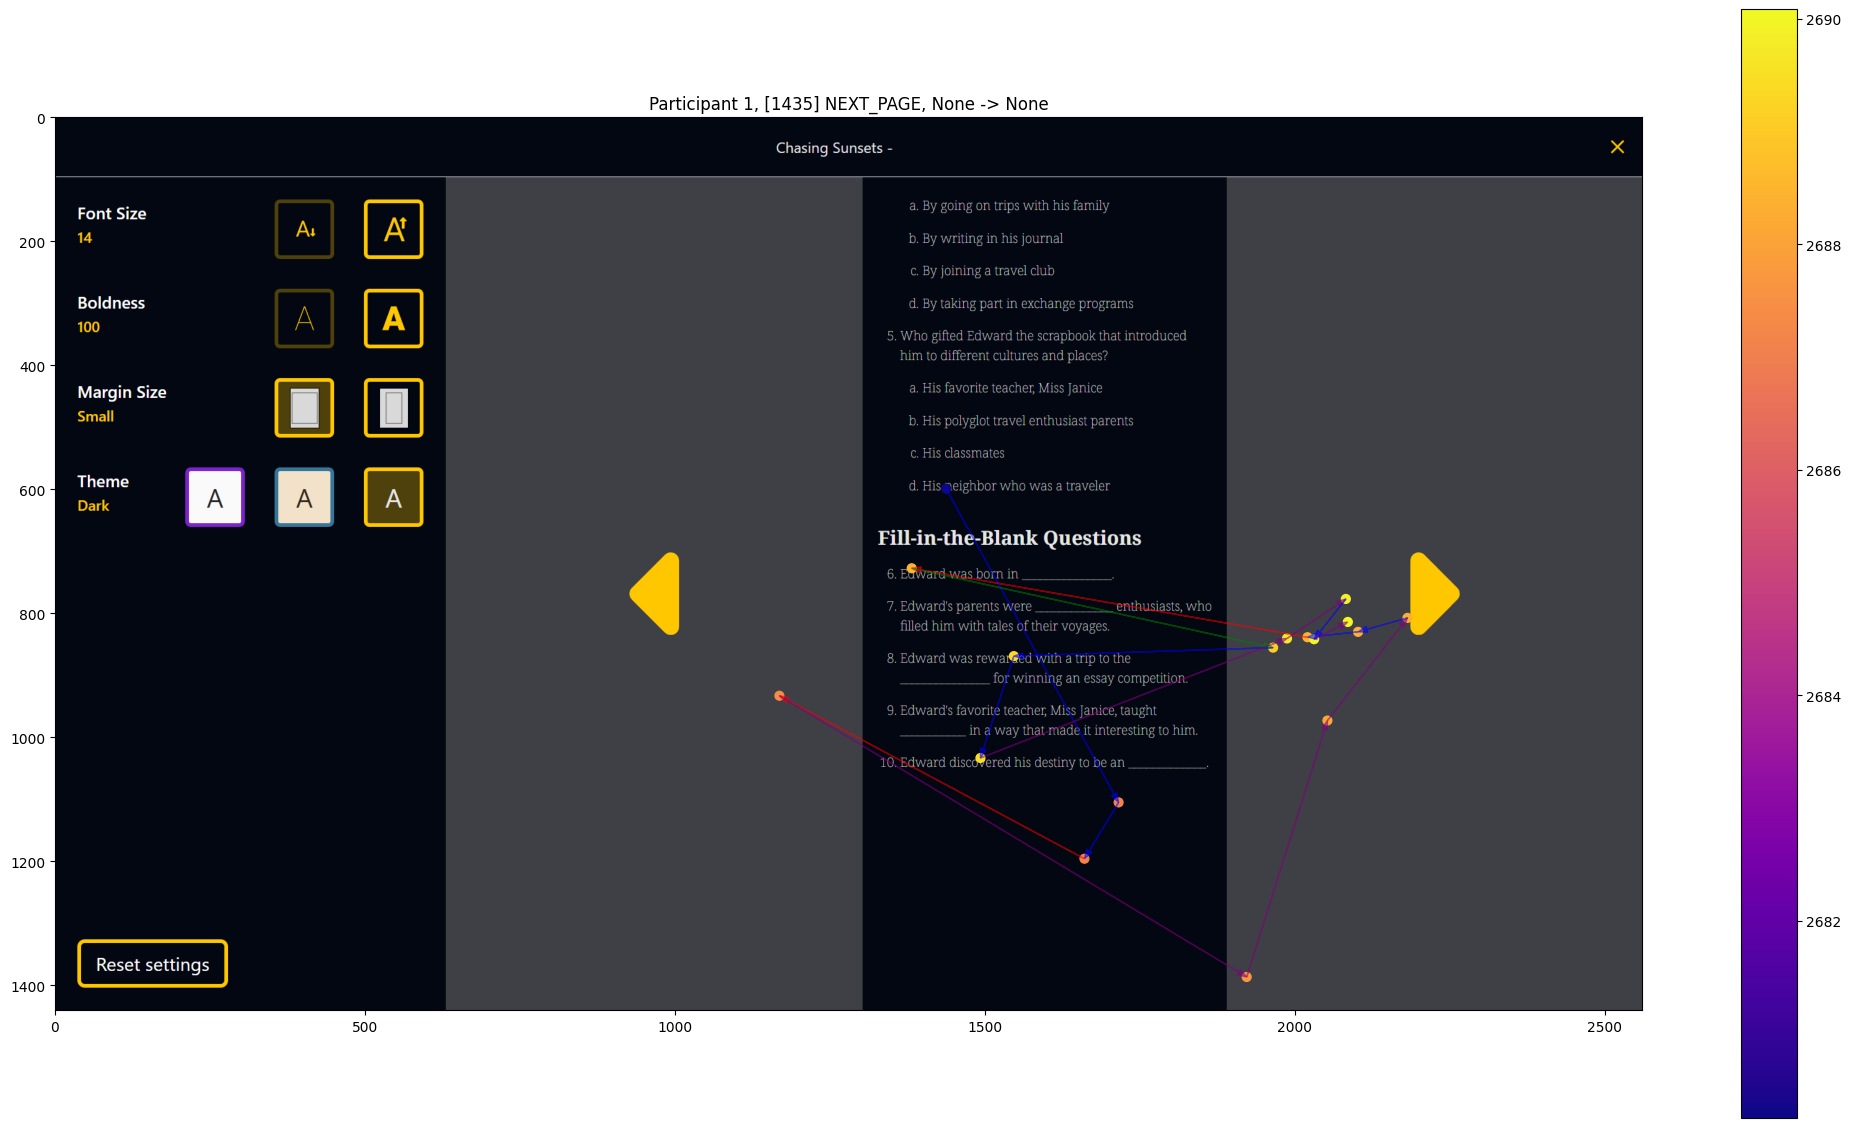

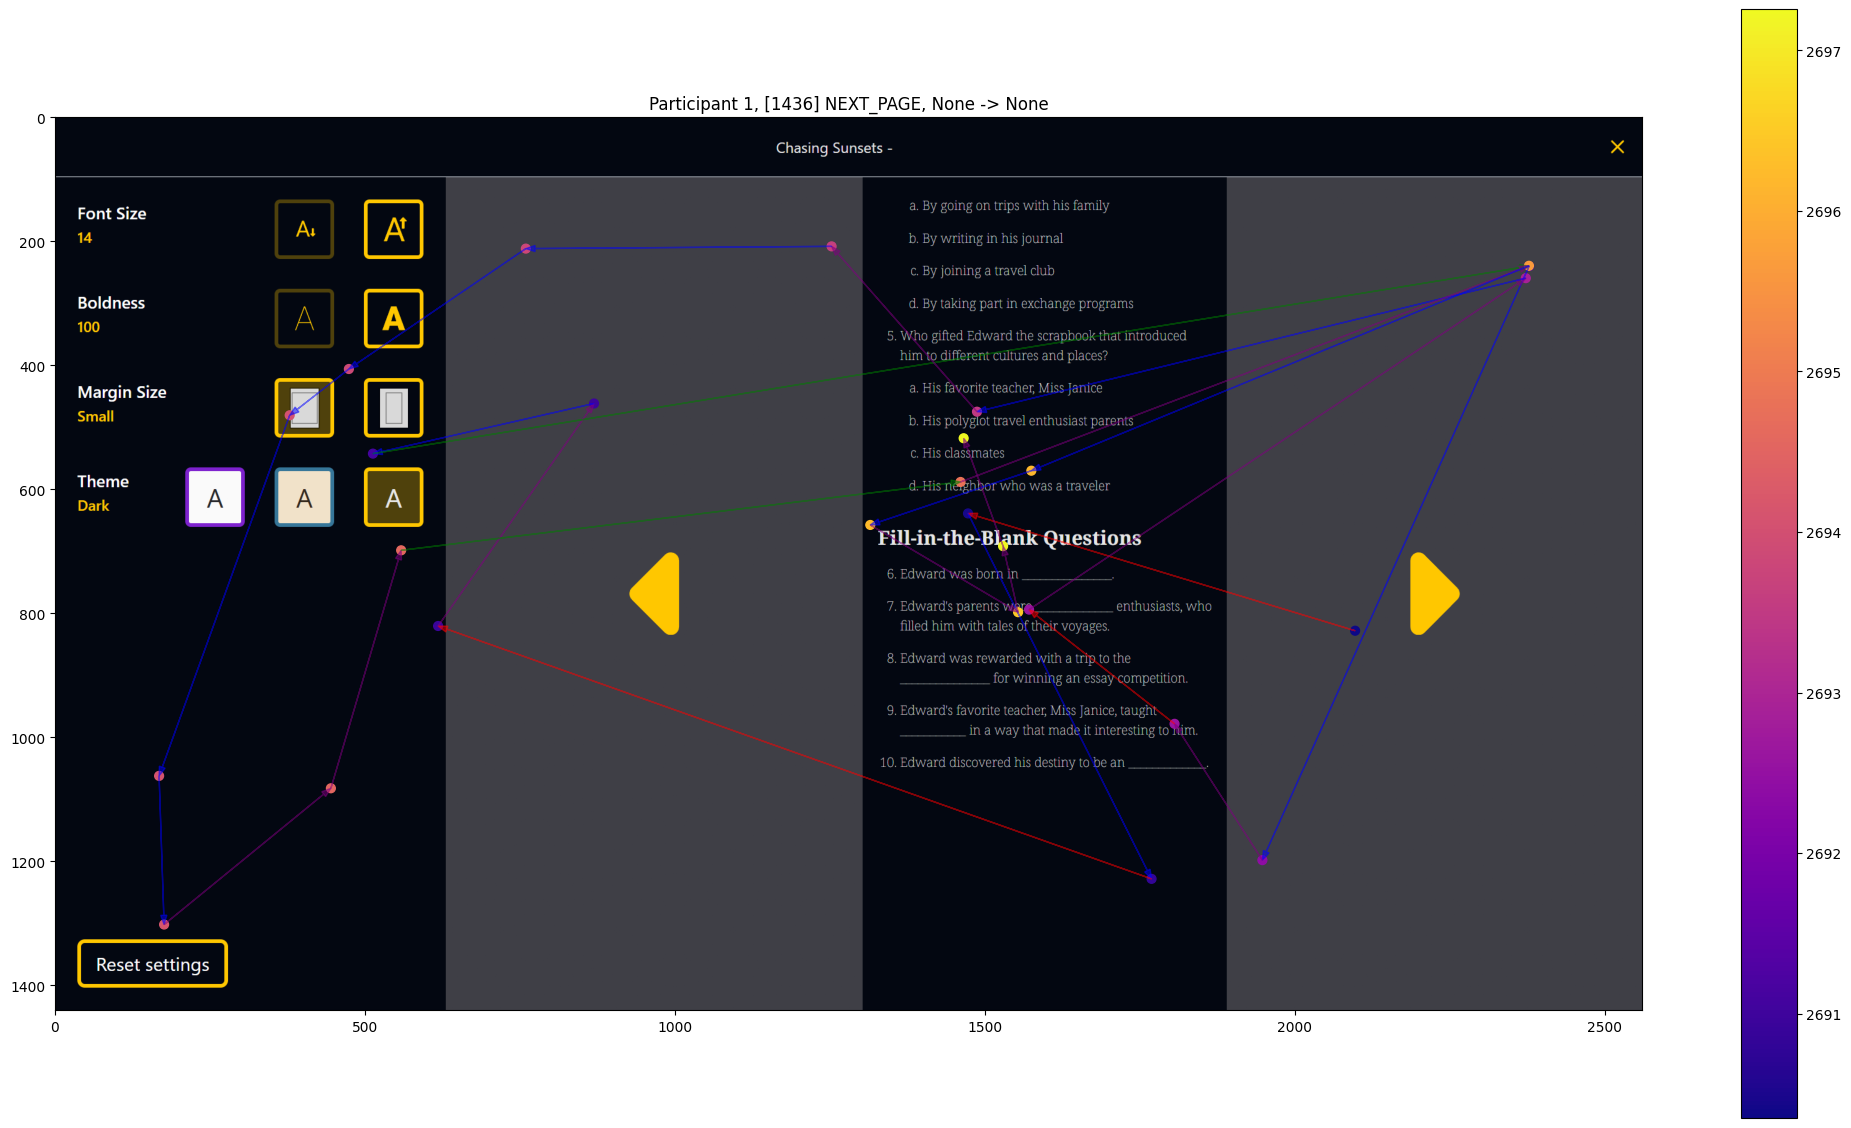

In [2]:
import os
from datetime import datetime

from utils import Events, extract_gaze_data_between_timestamps_proper

# participants that were told that they can change the settings beforehand
participant_ids = [1]

# get the events
for participant in participant_ids:
  events = Events.select().where(Events.participant_id==participant)

  current_json_file = None
  batches_of_events = {}
  current_batch = []
  for event in events:
    if event.event == "SELECT_TREATMENT":
      continue
    elif event.event == "CLOSE_BOOK":
      current_batch.append(event)
      batches_of_events[current_json_file] = current_batch
      current_batch = []
    elif event.event == "OPEN_BOOK":
      timestamp = event.time
      date = datetime.fromtimestamp(timestamp /1000)
      date_string = date.strftime("%Y-%m-%d_%H-%M-%S")
      current_json_file = f"[{participant}]-{date_string}.json"
      current_batch.append(event)
    else:
      current_batch.append(event)

  # for each json file, get the gaze data
  for json_file, events in batches_of_events.items():
    # get the gaze data for this participant
    # the files are in eye_tracker_data/
    path = "eye_tracker_data/"

    # for start_event in events:
    gaze_data_filename = json_file
    gaze_data_filepath = os.path.join(path, gaze_data_filename)
    # Read the file
    import json
    with open(gaze_data_filepath, "r") as f:
      gaze_data = json.load(f)

    pairs = list(zip(events, events[1:]))
    for begin_page_event, end_page_event in pairs:
      T_start = begin_page_event.time
      T_end = end_page_event.time

      # ignore the event if the participant only looked at this page for less than 5 seconds
      if T_end - T_start < 5_000:
        continue
      gaze_data_between_pageturn_events = extract_gaze_data_between_timestamps_proper(gaze_data, T_start, T_end)
      screenshot_path = begin_page_event.screenshot_file
      SACCADIC_THRESHOLD = 160
      plot_fixations_on_screenshot(gaze_data_between_pageturn_events, screenshot_path, title=f"Participant {participant}, [{begin_page_event.id}] {begin_page_event.event}, {begin_page_event.old_value} -> {begin_page_event.new_value}", saccadic_threshold=SACCADIC_THRESHOLD)
